# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# magic word for producing visualizations in notebook
%matplotlib inline

from IPython.display import display
import pickle

import warnings
warnings.filterwarnings('ignore')

# central project class
from utils.df_proj import DfProj
# generic reporting class for some prints and plots
from utils.df_stat import DfStat
# generic preprocessing
from utils.df_data_prep_01 import DfDataPrep01 
# project specific preprocessing
from utils.df_data_prep_02 import DfDataPrep02 
# do pca
from utils.df_pca import DfPca
# do kmeans
from utils.df_kmeans import DfKmeans 
# do supervise learning modell training 
from utils.sl_segment import SLSegment  

# ---------------------------------------------------
# global parameters 
# ---------------------------------------------------
# True - make the plots
GC_PLOT = True  
# True = make the prints
GC_PRINT = True  
GC_MAX_NAN_COLUMNS = 0 
# max number of rows read from the data file (0=all)
GC_MAX_ROWS = 0

# estimators used for the Supervised Machine Learning part 
# because of problmes with an old joblib version, the 
# BalancedRandomForestClassifer doesn't run here 
# on a local notebook
GC_ESTIMATORS = ['LOGREG', 'RANFOR', 'BALRANFOR', 'XGB']
# for the Udacity workspace use
# GC_ESTIMATORS = ['LOGREG', 'RANFOR', 'XGB']

# import importlib
# importlib.reload(df_data_prep_01)
print('done')

done


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

<div class="alert alert-block alert-warning">
    <b>Prerequisites</b>

A few changes are made which needs to be considered: 
- All the data files have been copied to a folder with the name "data" and read from there.
- The file "DIAS Information Levels - Attributes 2017.xlsx" was modified by adding the column "Data Type". The column values were maintained manually to define the data as numeric or categorical. Based on that information later the data cleaning is done. "_CHANGED" was added to the file name to indicate the change. 
- Please run the script "bash pip_install.sh" before running the workbook in the Udacity workspace. The script installs the xgboost and the imblearn module and updates the scikit-learn module.
- The BalancedRandomForest classifier needs a certain joblib version which cannot be installed in the Udacity workspace. Please use global parameter GC_ESTIMATORS = ['LOGREG', 'RANFOR', 'XGB'] instead of  GC_ESTIMATORS = ['LOGREG', 'RANFOR', 'BALRANFOR', 'XGB'] to suppress running the BalancedRandomForest estimator.
- There are some other global parameters which are used to control the runtime behavior like the GC_MAC_ROWS which can be used to read only a certain number of rows from the data set (GC_MAX_ROWS=0 -> read all rows wanted). 
</div>

# Approach

4 different data files with user data have to be considered in getting the final prediction: 

1. The general population data
2. The customers data with people who are already customers  
3. The mailout data with people who are part of a mail compaign with a response information and 
4. the mailout data with people who are part of a mail compaign without the reponse information.

Each of this dataset is processed in a similar way.

There are 2 additional files with master data which describe what the different columns in the dataset above contain. 

5. The information level file which contains a short description of most of the columns (not for all).
6. The attribute value file which lists for most of the columns the possible values with a short description of the value (not for all).

## Central Dictionaries

3 central dictionaries are created to support the data processing during the different steps:
- __Column Dictionary__<br>
Based on this 2 files a central column dictionary is created which contains all the necessary values to make the data cleaning like the data type and the ratio of missing values. 

- __Master Data Dictionary__<br>
Based on the attributes file a central master data dictionary was created to allow a lookup of attribute descriptions in plots.  

- __Model Dictionary__<br>
A lot of the data processing methods are using models with a instantiate and fit approach. To reuse the created models they are stored in a model dictionary. The models for imputing and scaling are f.i. created once and then reused for all the other data. 

## Preprocessing


Machine learning algorithm are using heavily matrix operations and they doesn't like null and non-numerical values. A big part of the preprocessing is necessary to replace such values by "proper" numerical values which they can process. 

- Load the data ( files 1, 2, 3, 4) 
- [Clean the data](#GEN_DATA_CLEAN) (files 1, 2, 3, 4)  
    - Delete columns which are not or only partially filled 
    - Delete rows with a high rate of empty columns
    - Reencode values mainly by replacing categorical by numerical values 
    - OneHot Encoding by replacing multi categorical values by creating new columns with a binary encoding 0  or 1 <br> ( files 1, 2, 3, 4)
- [Impute](#GEN_IMPUTE) missing values by the mean or the mode (files 1, 2, 3, 4) 
- Standardize numerical values to a similar range to shift the distribution to have a mean of zero and a standard deviation of one (files 1, 2, 3, 4) 
  

## Unsupervised Learning
- Use the [Principal Component Analysis (PCA)](#GEN_PCA) to get a reduced feature set (files 1, 2, 3, 4).
- Use [KMeans](#GEN_KMEANS) to identify a certain amount of clusters the user can be grouped in (files 1, 2, 3, 4).

## Supervised Learning 
- Make some classification by [using the models](#MAILOUT_SL_BUILD) Logistic Regression, Random Forest, BalancedRandomForced and Agboost (files 3, 4) 




In [2]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
# print('azdias', azdias.shape)
# azdias.head(10)

In [4]:
# print('customers', customers.shape)
# customers.head()

In [5]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## General Population - Preprocessing - Load the Data 

### Data Loading
In a 1st load the data for the general population, the customer data and the master data is loaded. 
The global parameter GC_MAX_ROWS can be used to reduce the rows read from the files. At the beginning it is often useful to work only on a small number of rows because that reduces the runtime. If the notebook is stable enough the row number can be increased easily. Because all was developed locally and because of performance problems even at the end only 20% of the data was used here to train the model (read_csv().sample()). In a productive environment all the possible data should be used if possible.  

### Data Dictionary 
MASTER_DIC_GEN and COLS_DIC_GEN are the central dictionaries for all the information around the columns which might be useful during the processing of the data. Such central standardized dictionaries can be used to reuse major parts of coding once written.  

To be honest I'm not happy with the current status of that dictionaries but for me as a beginner it is a starting point. 
Some information regarding the column dictionary:

- Datatype (categorical, numerical)<br>
Can be used to decide which imputer method should be used or if one hot encoding is necessary.
- Skip<br>
Based on different criterias, columns flagged as Skip=True will be deleted, f.i. if too much column values are empty.
- Unique_Values<br>
A few examples of the column just to get an impression what is the content of the column.
- Unknown_Ratio<br>
Rate of cells in a column which are empty. Depending on a given threshold columns will be deleted.
- Unknown_List<br>
If the data is collected based on a survey, perhaps it is possible to select an item like "unknown" which is different from not filled out. How to handle such values depends on the use case. "unknown" could be handled f.i. as NaNs to let the imputer fill that values with a mean or mode value. 

### Different Column Numbers
During the preprocessing of the data it can happen that the number of columns vary especially when methods like deleting sparse columns or onehot encoding to transform categorical columns are used. Such differences can be cumbersome to handle but it is important to fix that because models partially requests the same amount of columns if reused. Because columns are deleted or created based of the the values the column contain, for different data sets different columns are affected. If a certain value is not part of a dataset a onehot encoder will not create a separate 0/1 column for it. To handle such cases the method "print_colcompare" is used. The flag "p_add" can be used to let the method create or delete columns which doesn't match. 


In [6]:
# ---------------------------------------------------
# load data 
# ---------------------------------------------------
o_df_proj = DfProj(p_plot = GC_PLOT, p_print = GC_PRINT, p_max_rows=GC_MAX_ROWS) 
azdias, customers, feat_info, feat_attr, master_dic_gen, cols_dic_gen, \
    models_dic_gen = o_df_proj.get_data( )

o_df_stat = DfStat(azdias, cols_dic_gen) 
if GC_PRINT == True:
    #  Reporting 
    o_df_stat.print_no( )     
    # compare the columns of the general and the customer dataset 
    df_check_gen, df_check_cust = o_df_stat.print_colcompare(azdias, customers, False)  

# customer columns which are not in the general dataset 
if 'PRODUCT_GROUP' in customers.columns:
    remove_cols = ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
    customers = customers.drop(axis = 1, columns = remove_cols )

print('Gen/Customer', azdias.shape, customers.shape) 

2022-04-13 11:45:16.383773+00:00 Load Data --------------------------------------
 general / customer:  (178244, 366) (38330, 369) 

column not in feature dictionary LNR
column not in feature dictionary AKT_DAT_KL
column not in feature dictionary ALTER_KIND1
column not in feature dictionary ALTER_KIND2
column not in feature dictionary ALTER_KIND3
column not in feature dictionary ALTER_KIND4
column not in feature dictionary ALTERSKATEGORIE_FEIN
column not in feature dictionary ANZ_KINDER
column not in feature dictionary ANZ_STATISTISCHE_HAUSHALTE
column not in feature dictionary CAMEO_INTL_2015
column not in feature dictionary CJT_KATALOGNUTZER
column not in feature dictionary CJT_TYP_1
column not in feature dictionary CJT_TYP_2
column not in feature dictionary CJT_TYP_3
column not in feature dictionary CJT_TYP_4
column not in feature dictionary CJT_TYP_5
column not in feature dictionary CJT_TYP_6
column not in feature dictionary D19_BANKEN_ANZ_12
column not in feature dictionary D19_BA

<a id="GEN_DATA_CLEAN"></a>
## General Population - Preprocessing - Clean Data

The clean data method consists of the following steps: 
1. Delete columns which are not filled out properly.
2. Delete rows which are mostly empty.
3. Reencode data  

The reencoding depends heavily on the given data to replace categorical by numerical values. In the project a lot of hand made encoding is done like for the OST_WEST_KZ or for the CAMEO- columns. That is certainly useful at the beginning to get acquainted with data frame manipulation. But later perhaps we should give the LabelEncoder of the scikit-learn preprocessing modul a trial which perhaps does a much better job. 

<b>OneHot Encoding</b><br>
During the reencoding for the categorical columns with many different values, a onehot encoding is used to convert the categorical values into numbers which is necessary because machine learning algorithm cannot handle categorical values. 

Basically for all different values in a column a new separate column will be created which is flagged as 1 if the cell contains such value. That can heavily explode the number of columns. F.i. for a column with the fruits apple, bananas and pears 3 new column fruit_apple, fruit_bananas and fruit_pears will be created where a 1 is set in the corresponding new column if the original columns contains such a value otherwise 0. Module will handle that for us. 

    ´fruit  --> fruit_apple    fruit_banane    fruit_pears´
    apple       1              0               0     
    banane      0              1               0
    apple       1              0               0     
    pears       0              0               1

A few bar plots are used for the deleted columns to get an impression of the distribution of that columns. A print of the column dictionary selected by the skip parameter gives an indication why the column was deleted. 

The old and new values are printed together with the column for which the reencoding is done which facilitates searching for errors even if that explodes the length of the notebook. With the global parameters GC_PRINT and GC_PLOT the print and plot statements can be de-activated. If the notebook runs stable and all the pecularities are identified, then most of the outputs are not necessary any more. 

column not in feature dictionary LNR
column not in feature dictionary AKT_DAT_KL
column not in feature dictionary ALTER_KIND1
column not in feature dictionary ALTER_KIND2
column not in feature dictionary ALTER_KIND3
column not in feature dictionary ALTER_KIND4
column not in feature dictionary ALTERSKATEGORIE_FEIN
column not in feature dictionary ANZ_KINDER
column not in feature dictionary ANZ_STATISTISCHE_HAUSHALTE
column not in feature dictionary CAMEO_INTL_2015
column not in feature dictionary CJT_KATALOGNUTZER
column not in feature dictionary CJT_TYP_1
column not in feature dictionary CJT_TYP_2
column not in feature dictionary CJT_TYP_3
column not in feature dictionary CJT_TYP_4
column not in feature dictionary CJT_TYP_5
column not in feature dictionary CJT_TYP_6
column not in feature dictionary D19_BANKEN_ANZ_12
column not in feature dictionary D19_BANKEN_ANZ_24
column not in feature dictionary D19_BANKEN_DIREKT
column not in feature dictionary D19_BANKEN_GROSS
column not in featur

,col_name,type,datatype,inttype,skip,desc,nan_cnt,nan_ratio,unique_cnt,unique,unknown,unknown_cnt,unknown_rate,unknown_skip,unknown_list,skip_reason,not_in_dic
AGER_TYP,AGER_TYP,int64,categorical,True,True,best-ager typology,0,0.000000,5,"[-1, 2, 1, 3, 0]",-1,135463,0.759986,True,"[-1, nan]",high rate of NaNs,
ALTER_KIND1,ALTER_KIND1,float64,,True,True,,161993,0.908827,17,"[nan, 11.0, 8.0, 13.0, 17.0]",,161993,0.908827,True,[nan],high rate of NaNs,X
ALTER_KIND2,ALTER_KIND2,float64,,True,True,,172294,0.966619,16,"[nan, 15.0, 16.0, 11.0, 10.0]",,172294,0.966619,True,[nan],high rate of NaNs,X
ALTER_KIND3,ALTER_KIND3,float64,,True,True,,177002,0.993032,14,"[nan, 16.0, 13.0, 17.0, 15.0]",,177002,0.993032,True,[nan],high rate of NaNs,X
ALTER_KIND4,ALTER_KIND4,float64,,True,True,,178007,0.998670,11,"[nan, 13.0, 15.0, 16.0, 17.0]",,178007,0.998670,True,[nan],high rate of NaNs,X
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,float64,,True,True,,52409,0.294030,25,"[nan, 14.0, 16.0, 10.0, 0.0]",,52409,0.294030,True,[nan],high rate of NaNs,X
D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,10,"[0.0, nan, 10.0, 9.0, 7.0]",,51321,0.287926,True,[nan],high rate of NaNs,
D19_GESAMT_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,11,"[0.0, 10.0, 4.0, nan, 5.0]",,51321,0.287926,True,[nan],high rate of NaNs,
D19_KONSUMTYP,D19_KONSUMTYP,float64,categorical,True,True,consumption type,51321,0.287926,7,"[2.0, 9.0, 6.0, 1.0, nan]",,51321,0.287926,True,[nan],high rate of NaNs,
D19_LETZTER_KAUF_BRANCHE,D19_LETZTER_KAUF_BRANCHE,object,categorial,False,True,,51321,0.287926,35,"[D19_TECHNIK, D19_UNBEKANNT, D19_SCHUHE, D19_B...",,51321,0.287926,True,[nan],high rate of NaNs,X


meplot True


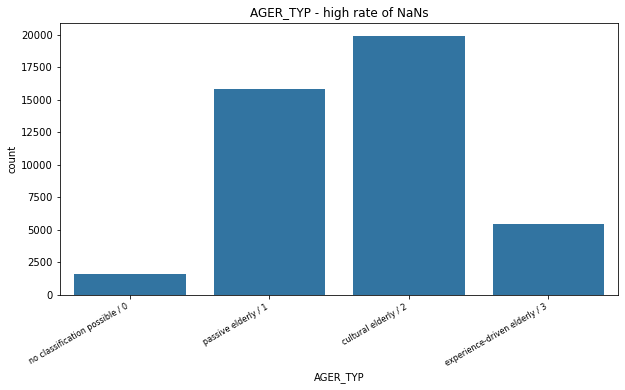

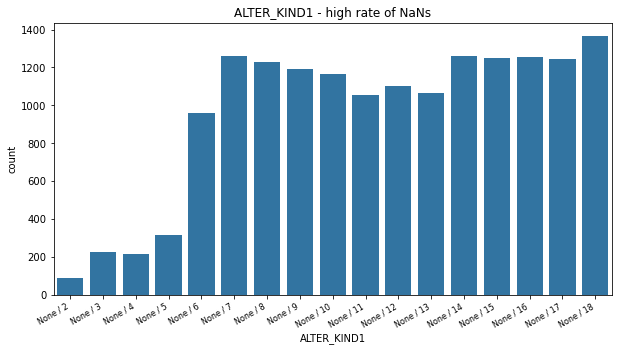

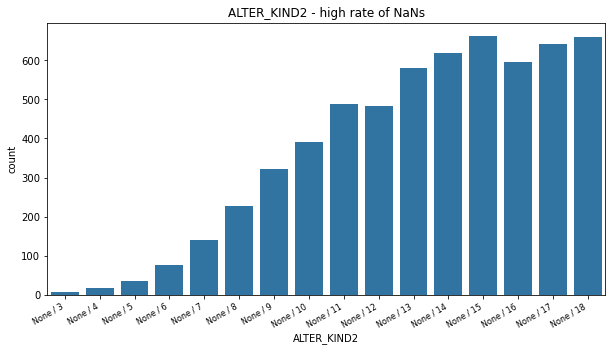

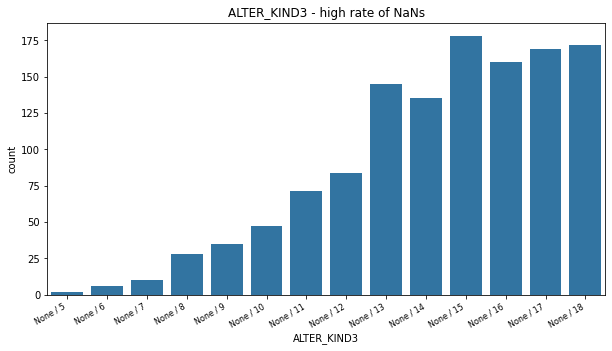

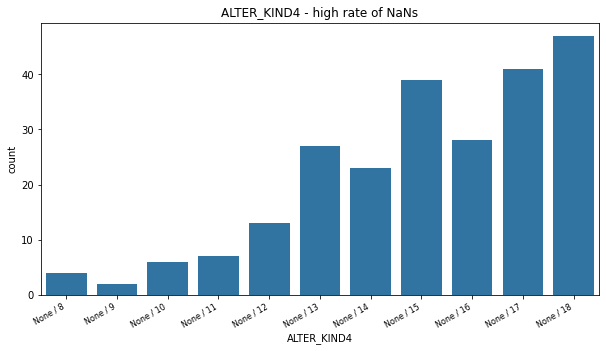

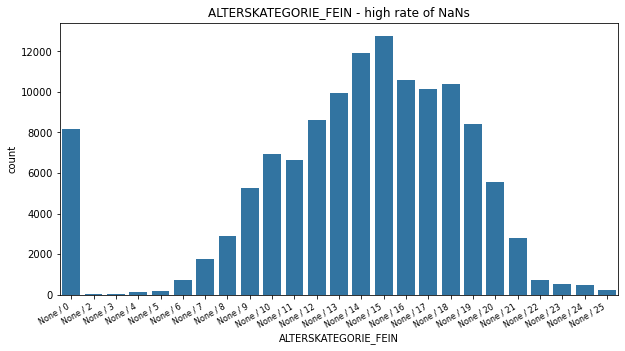

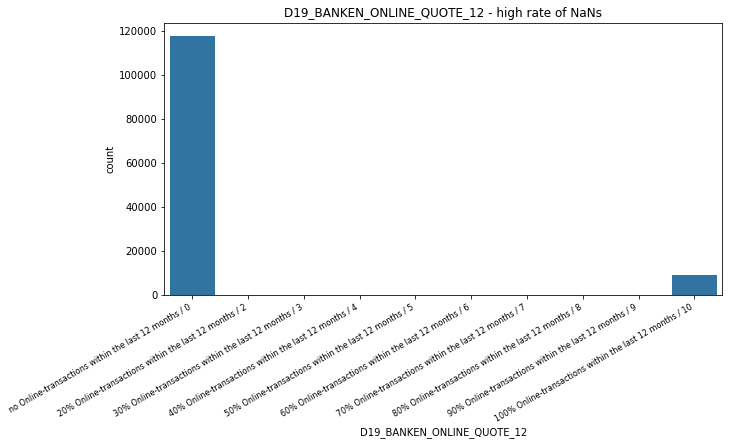

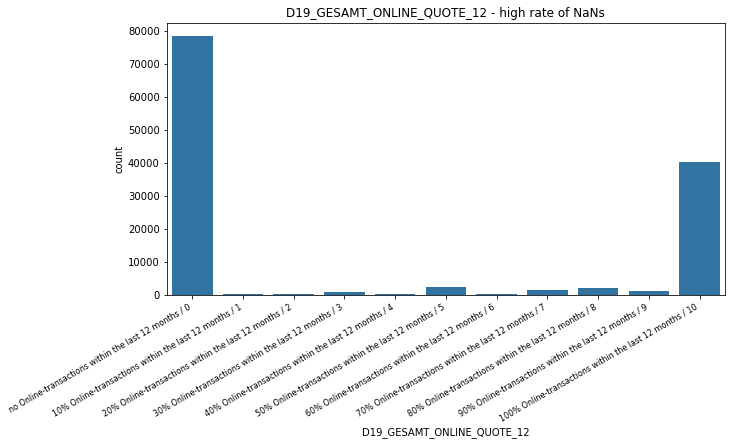

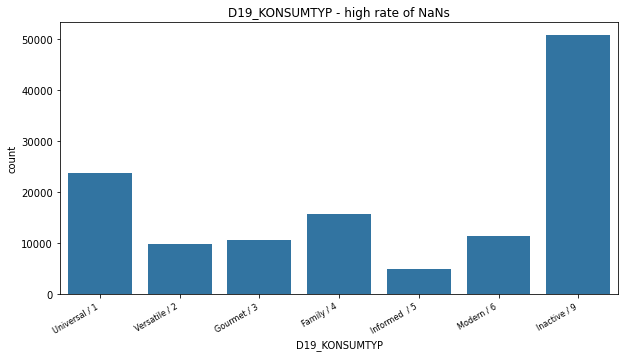

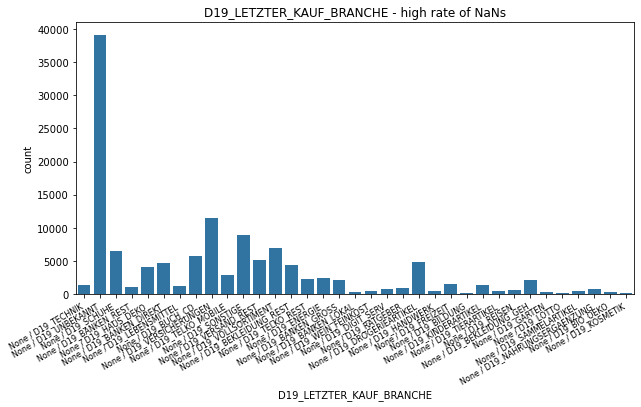

remove AGER_TYP
remove ALTER_KIND1
remove ALTER_KIND2
remove ALTER_KIND3
remove ALTER_KIND4
remove ALTERSKATEGORIE_FEIN
remove D19_BANKEN_ONLINE_QUOTE_12
remove D19_GESAMT_ONLINE_QUOTE_12
remove D19_KONSUMTYP
remove D19_LETZTER_KAUF_BRANCHE
remove D19_LOTTO
remove D19_SOZIALES
remove D19_TELKO_ONLINE_QUOTE_12
remove D19_VERSAND_ONLINE_QUOTE_12
remove D19_VERSI_ONLINE_QUOTE_12
remove EXTSEL992
remove KBA05_BAUMAX
remove KK_KUNDENTYP
remove TITEL_KZ
DataFrame after Column Deletion: (178244, 347)
2022-04-13 11:48:49.813787+00:00  Preprocessing - Remove Nan Rows ---------------
Rows NaN:  55608  Rows not-Nan:  122636
2022-04-13 11:48:51.824790+00:00  Feature Reencoding-----------------------------
OST_WEST_KZ --------------------
old ['W' 'O']
new [0 1]
CAMEO_DEUG_2015
old ['5' '9' '3' 3.0 '4' '2' 7.0 4.0 1.0 '8' '6' 8.0 '7' 9.0 6.0 2.0 '1' 5.0
 'X']
new [ 5.  9.  3.  4.  2.  7.  1.  8.  6. nan]
CAMEO_DEU_2015 --------------------
old ['5B' '9A' '3A' '3D' '4C' '2D' '7A' '2A' '3C' '1A' '8B'

In [7]:
# ---------------------------------------------------
# clean data - AZDIAS
# ---------------------------------------------------
df_clean_gen, cols_dic_gen, models_dic_gen, GC_MAX_NAN_COLUMNS = \
        o_df_proj.clean_data(azdias, [], GC_MAX_NAN_COLUMNS)
print('General shape - cleaned', df_clean_gen.shape)

<a id="GEN_IMPUTE"></a>
## General Population - Preprocessing - Imputing 
https://www.askpython.com/python/examples/impute-missing-data-values

Missing values in columns will be replaced by "other" more proper values because machine learning models doesn't like such values. 

Reasons (s. link above): 
- Reduces the efficiency of the ML model.
- Affects the overall distribution of data values.
- It leads to a biased effect in the estimation of the ML model.

Imputing is done by the used moduls for Nan values so that it is important to transform missing values like "unknown" to NaNs to let the modul handle them in the same way if the context allows that. NaNs are replaced by the mean for numerical values and by the mode for categorical values here because the mean isn't so useful for the categorical values.   

In [8]:
# ---------------------------------------------------
# imputing - AZDIAS
# --------------------------------------------------- 
df_imputed_gen, models_dic_gen = DfDataPrep01.do_imputing_mean(
    df_clean_gen, 'mean', models_dic_gen )
print('General Shape imputed', df_imputed_gen.shape)

2022-04-13 11:48:58.617933+00:00  feature imputing ------------------------------
General Shape imputed (122636, 664)


## Customers - Preprocessing - Clean Data

The same procedure used for the general population is used here again for the customer data. 

As already mentioned it is important to have a look at the column numbers resulting from the data cleaning. They should be identical to allow applying already created model instances. The PRINT_COLCOMPARE method is here used again. The True parameter triggers the deletion or creation of dummy columns if the column numbers differ. 


2022-04-13 11:49:27.856445+00:00  Preprocessing - Remove Nan Colums -------------
Columns to delete - skip=True
 (19, 17) 



,col_name,type,datatype,inttype,skip,desc,nan_cnt,nan_ratio,unique_cnt,unique,unknown,unknown_cnt,unknown_rate,unknown_skip,unknown_list,skip_reason,not_in_dic
AGER_TYP,AGER_TYP,int64,categorical,True,True,best-ager typology,0,0.000000,5,"[-1, 2, 1, 3, 0]",-1,18431,0.480851,True,"[-1, nan]",high rate of NaNs,
ALTER_KIND1,ALTER_KIND1,float64,,True,True,,161993,0.908827,17,"[nan, 11.0, 8.0, 13.0, 17.0]",,35942,0.937699,True,[nan],high rate of NaNs,X
ALTER_KIND2,ALTER_KIND2,float64,,True,True,,172294,0.966619,16,"[nan, 15.0, 16.0, 11.0, 10.0]",,37297,0.973050,True,[nan],high rate of NaNs,X
ALTER_KIND3,ALTER_KIND3,float64,,True,True,,177002,0.993032,14,"[nan, 16.0, 13.0, 17.0, 15.0]",,38062,0.993008,True,[nan],high rate of NaNs,X
ALTER_KIND4,ALTER_KIND4,float64,,True,True,,178007,0.998670,11,"[nan, 13.0, 15.0, 16.0, 17.0]",,38278,0.998643,True,[nan],high rate of NaNs,X
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,float64,,True,True,,52409,0.294030,25,"[nan, 14.0, 16.0, 10.0, 0.0]",,10394,0.271171,True,[nan],high rate of NaNs,X
D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,10,"[0.0, nan, 10.0, 9.0, 7.0]",,9576,0.249830,True,[nan],high rate of NaNs,
D19_GESAMT_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,11,"[0.0, 10.0, 4.0, nan, 5.0]",,9576,0.249830,True,[nan],high rate of NaNs,
D19_KONSUMTYP,D19_KONSUMTYP,float64,categorical,True,True,consumption type,51321,0.287926,7,"[2.0, 9.0, 6.0, 1.0, nan]",,9576,0.249830,True,[nan],high rate of NaNs,
D19_LETZTER_KAUF_BRANCHE,D19_LETZTER_KAUF_BRANCHE,object,categorial,False,True,,51321,0.287926,35,"[D19_TECHNIK, D19_UNBEKANNT, D19_SCHUHE, D19_B...",,9576,0.249830,True,[nan],high rate of NaNs,X


meplot True


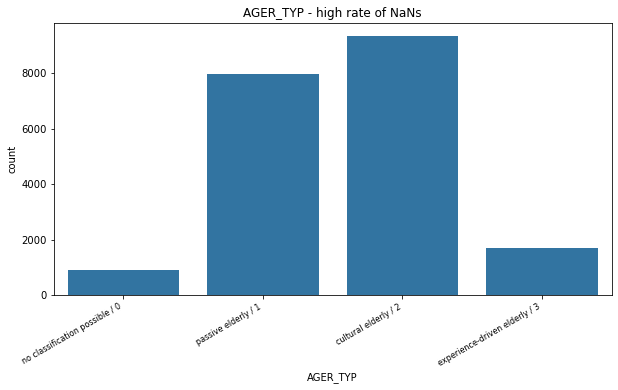

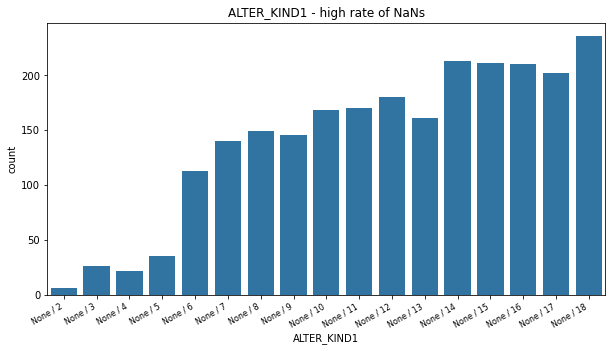

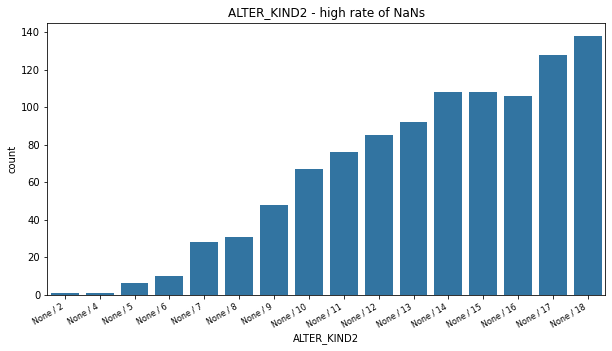

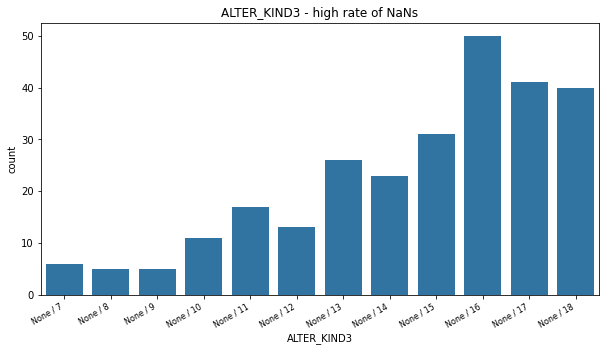

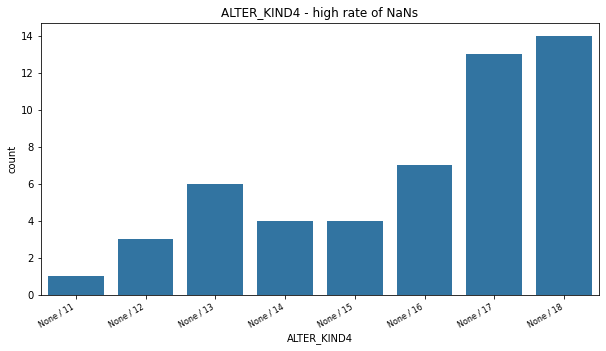

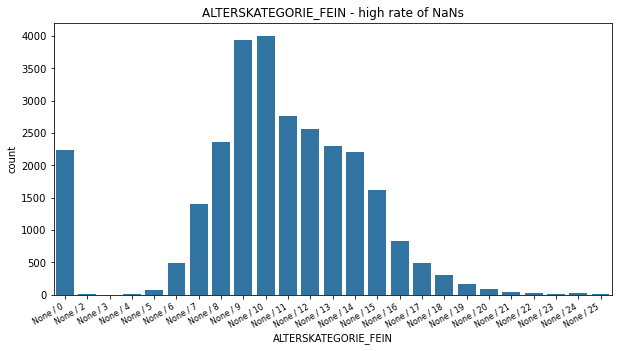

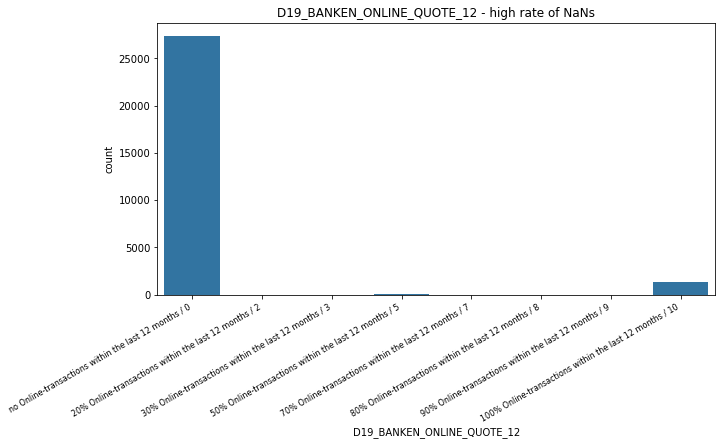

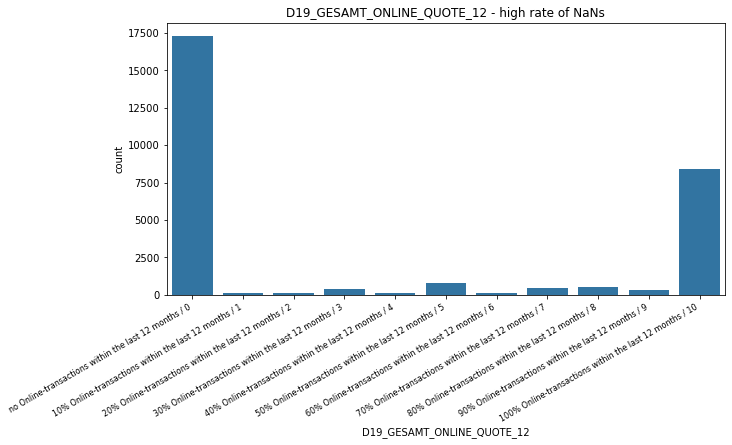

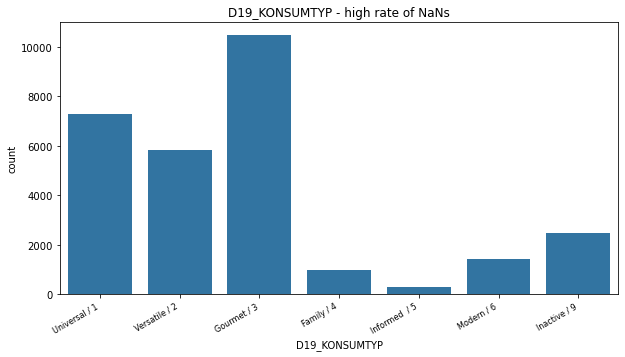

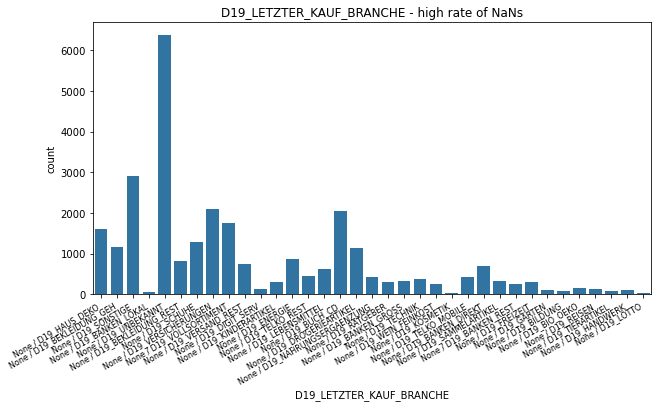

remove AGER_TYP
remove ALTER_KIND1
remove ALTER_KIND2
remove ALTER_KIND3
remove ALTER_KIND4
remove ALTERSKATEGORIE_FEIN
remove D19_BANKEN_ONLINE_QUOTE_12
remove D19_GESAMT_ONLINE_QUOTE_12
remove D19_KONSUMTYP
remove D19_LETZTER_KAUF_BRANCHE
remove D19_LOTTO
remove D19_SOZIALES
remove D19_TELKO_ONLINE_QUOTE_12
remove D19_VERSAND_ONLINE_QUOTE_12
remove D19_VERSI_ONLINE_QUOTE_12
remove EXTSEL992
remove KBA05_BAUMAX
remove KK_KUNDENTYP
remove TITEL_KZ
DataFrame after Column Deletion: (38330, 347)
2022-04-13 11:49:54.246842+00:00  Preprocessing - Remove Nan Rows ---------------
Rows NaN:  9464  Rows not-Nan:  28866
2022-04-13 11:49:54.685841+00:00  Feature Reencoding-----------------------------
OST_WEST_KZ --------------------
old ['W' 'O' nan]
new [ 0.  1. nan]
CAMEO_DEUG_2015
old ['3' '1' '8' '5' '6' '7' 8.0 '9' '2' 2.0 1.0 '4' 4.0 3.0 9.0 nan 5.0 6.0
 7.0 'X']
new [ 3.  1.  8.  5.  6.  7.  9.  2.  4. nan]
CAMEO_DEU_2015 --------------------
old ['3D' '1C' '8A' '5D' '1A' '6F' '7A' '9D' '

In [9]:
# ---------------------------------------------------
# clean data - CUSTOMERS
# ---------------------------------------------------
df_clean_cust, cols_dic_gen, models_dic_gen, GC_MAX_NAN_COLUMNS = \
    o_df_proj.clean_data(customers, cols_dic_gen, GC_MAX_NAN_COLUMNS)
print('Customer shape - cleaned', df_clean_cust.shape)

# compare the columns of the general and the customer dataset 
df_imputed_gen, df_clean_cust = o_df_stat.print_colcompare(df_imputed_gen, 
                                df_clean_cust, True, p_print=GC_PRINT) 
print('Gen/Customer', df_imputed_gen.shape, df_clean_cust.shape)

## Customers - Preprocessing - Imputing
Nothing new here as the same procedure used for the general population is used here again. The column compare is just a check to be sure that the column numbers haven't changed. 

In [10]:
# ---------------------------------------------------
# imputing - CUSTOMERS
# --------------------------------------------------- 
df_imputed_cust,  models_dic_gen = DfDataPrep01.do_imputing_mean(
    df_clean_cust, 'mean', models_dic_gen ) 

# compare the columns of the general and the customer dataset 
if GC_PRINT == True:
    df_imputed_gen, df_imputed_cust = o_df_stat.print_colcompare(df_imputed_gen, 
                                    df_imputed_cust, False) 
print('Gen/Customer - imputed', df_imputed_gen.shape, df_imputed_cust.shape)

2022-04-13 11:49:57.109489+00:00  feature imputing ------------------------------
Gen/Customer (122636, 664) (28866, 664)
Gen/Customer - imputed (122636, 664) (28866, 664)


## Scaling 
Before we can start with the feature reduction it is necessary to standardize the numerical feature values by using the StandardScale module. The PCA method is susceptible for biases caused by different value ranges between the features. If one feature has a value range from 1 to 100 and another feature from 1 to 100000, that can have an influence on the weights of such a feature for creating the PCA components we should avoid.

<a id="GEN_PCA"></a>
## General Population - Unsupervised Learning - Principal Component Analysis (PCA)
Due to the fact that the data source consists of many columns and the column exploding because of a onehot encoding the column number 662 is now reached. So many columns doesn't make the life easier and slow down the further data processing. Here PCA makes out of 662 columns only 80 columns with the hope that the 80 columns represent almost the same information than the 662 columns. 

PCA is used to reduce the columns or the so called features of a data set.  

I liked the following explanation which describes the PCA well.<br>
https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
> Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

PCA can use the fact that many features varying together like sunny days and the ice cream selling. PCA tries to create new features which explain the variance(info) in the data in the same way like the original features but now with less feature numbers. Weights are used to keep the influence of the original feature on the new created feature.  

By applying the PCA method unfortunately the new features or more precise principal components have a technical character and get a technical name. Out of our meaningful column names a new consecutive number for every component will be created.

A scatter plot helps to determine the number of components we would keep for further processing. With every additional component the explained variance of the component decreases so that at certain point further components doesn't influence much the information kept in our model. 

It is up to you to choose the number of components used for further processing. With a scatter plot it is easy to detect that the cumulative variances explained by each component increases slower with every component. Reaching a certain threshold of f.i. 80% determines the component number which should be chosen.  

<b>How can we interpret such a principal component?</b><br>
The main reason why we are using PCA is to reduce the feature number which will help to speed up the execution of our machine learning models. So basically it is not really necessary to say something about it. 

But it is possible to get the original columns/features with their weights for every component. It is again up to you to interpret the combination of original columns responsible for the component. 

The following table shows the influencing factors for component 2. It seems that component 2 has something to do with car ownership. Owners of the brands BMW & Mercedes contributes most to the explained variance. 
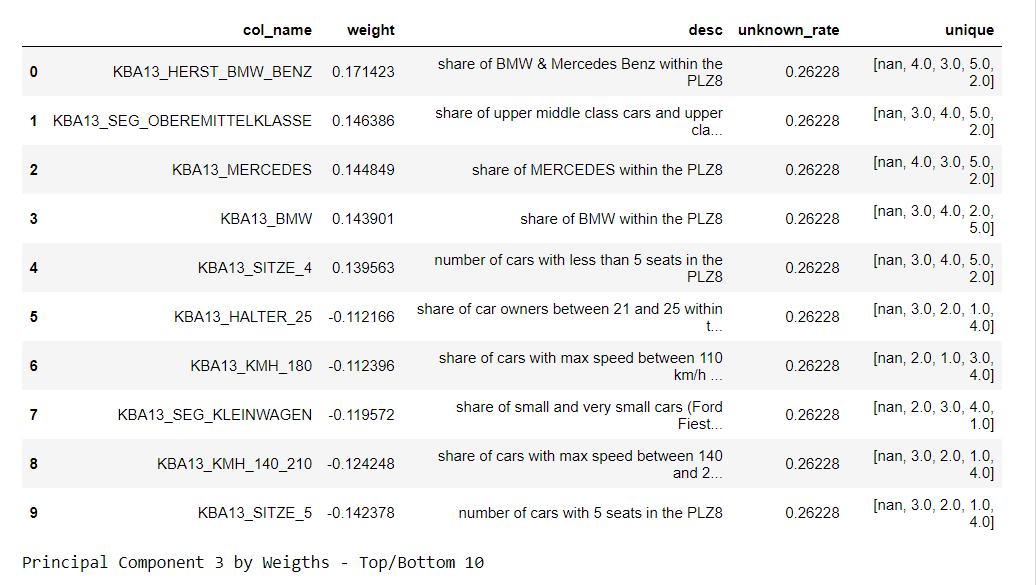



Looking at the data frame returned by the PCA model, for every person in our data set we can find certain values for every component. The values of column 2 belongs to our car ownership component.  

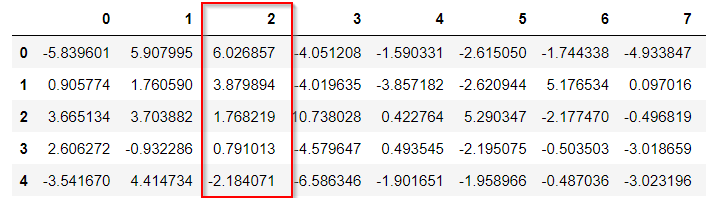

If the car ownership could be relevant for our email compaign perhaps we should extract people with a high column 2 value. But to be honest it is not so easy to explain the PCA values to someone else especially when considering how such values are calculated by using eigenvalues and eigenvectors. 

2022-04-13 11:49:59.941938+00:00  General PCA -----------------------------------
new scaler
new pca model


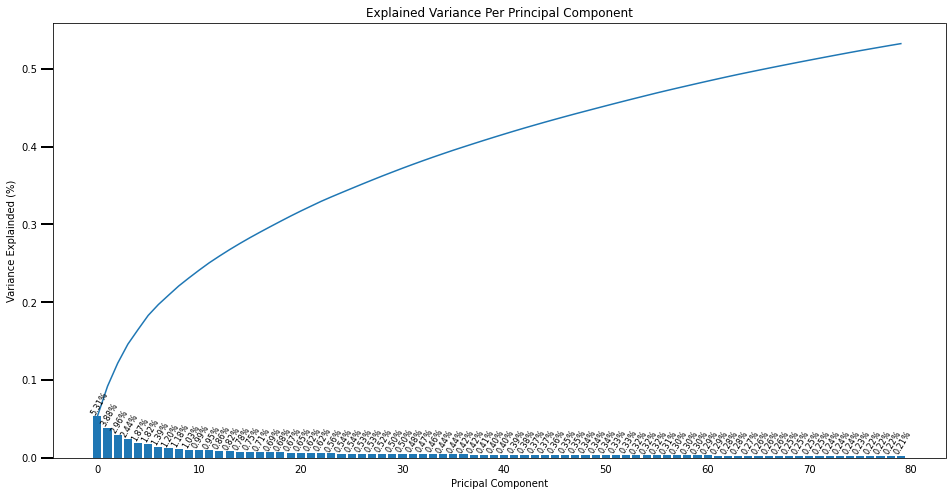

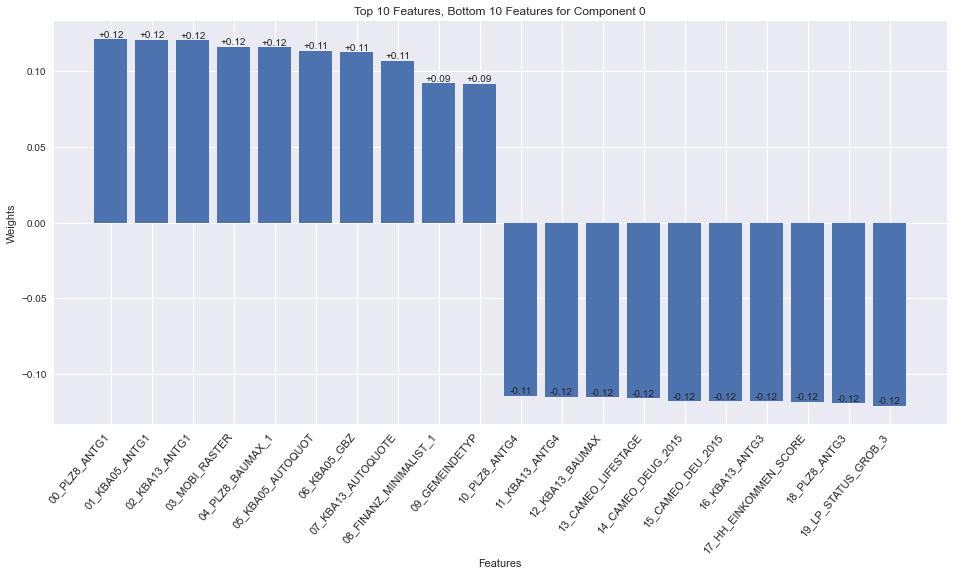

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


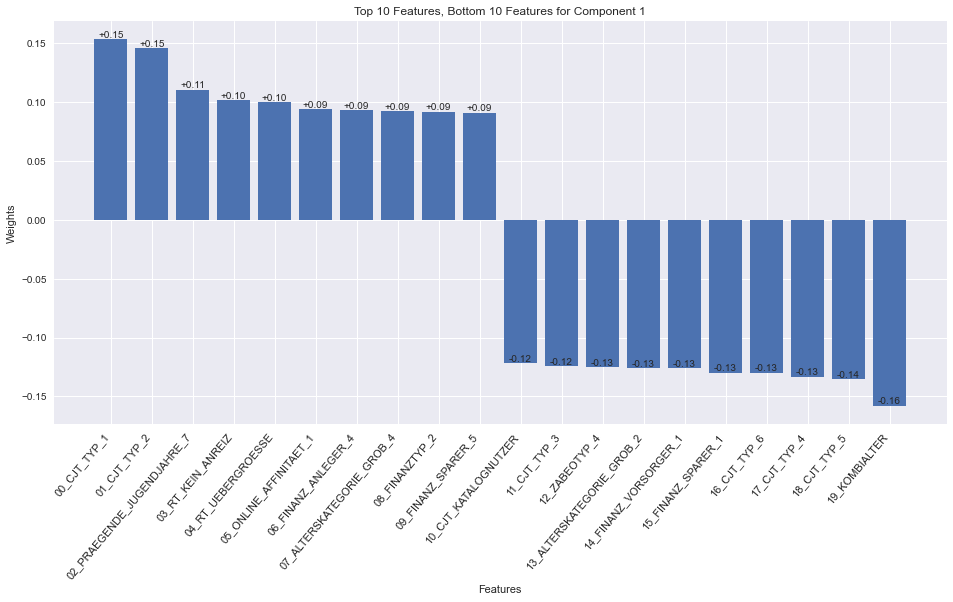

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


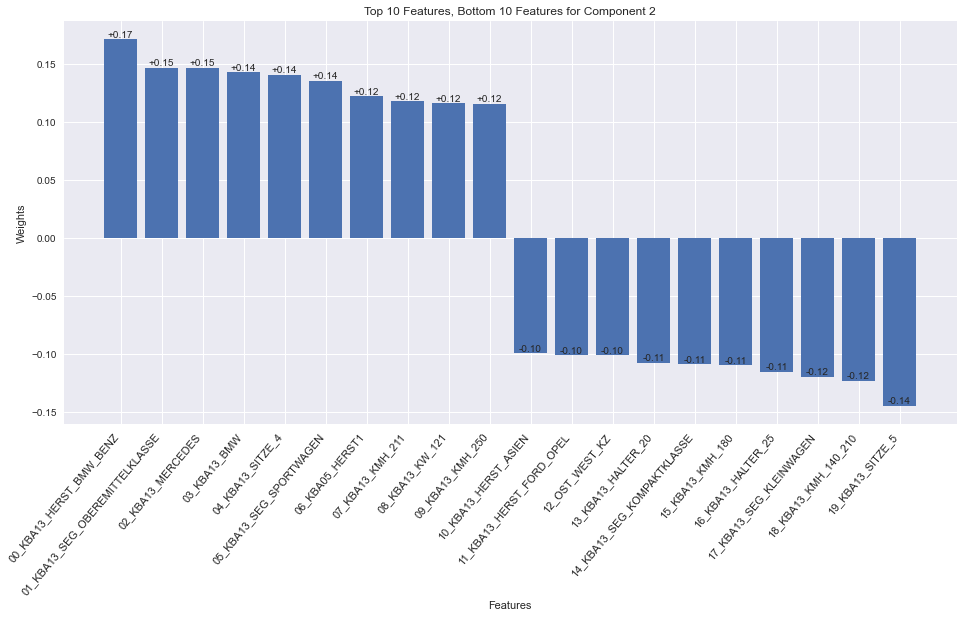

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


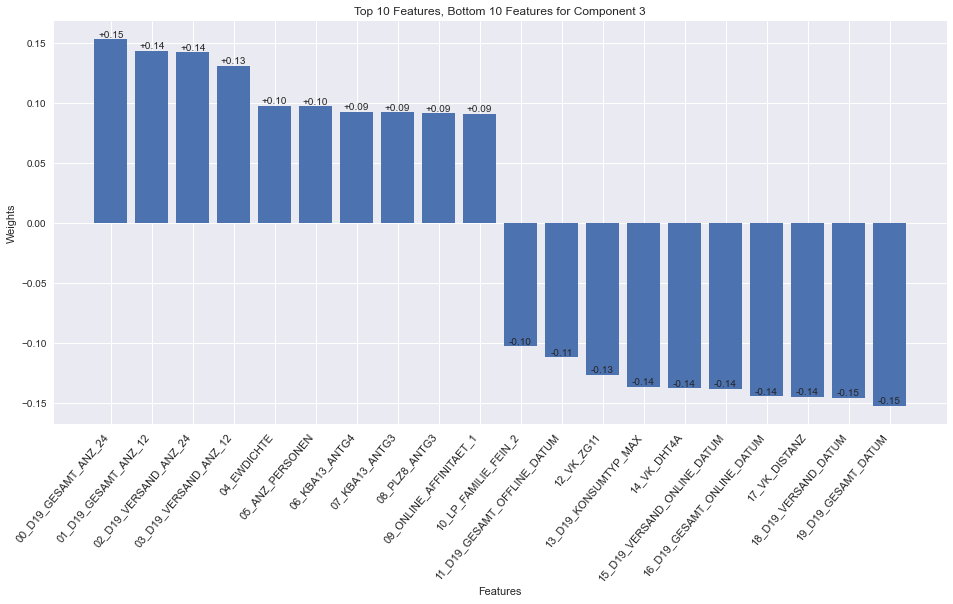

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


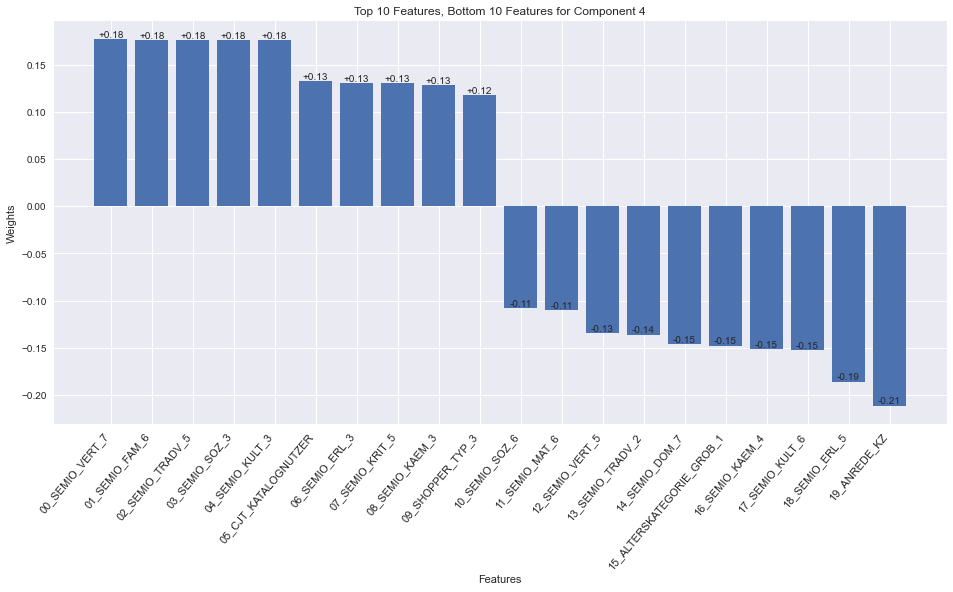

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


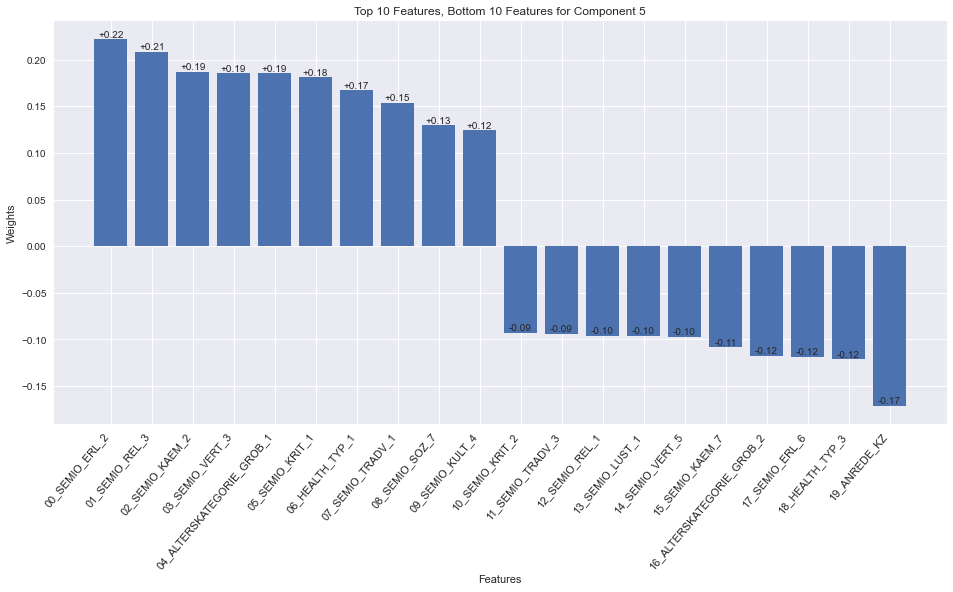

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


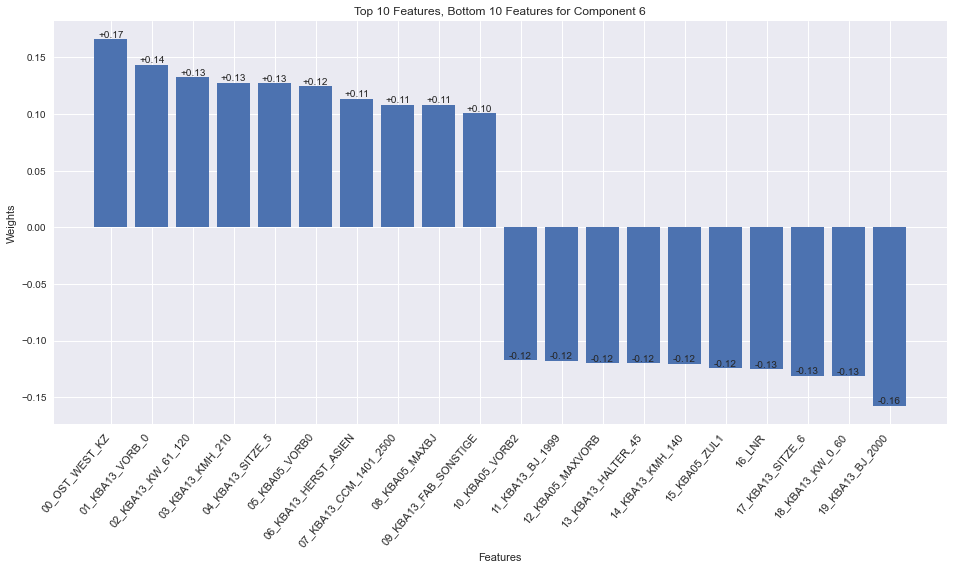

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


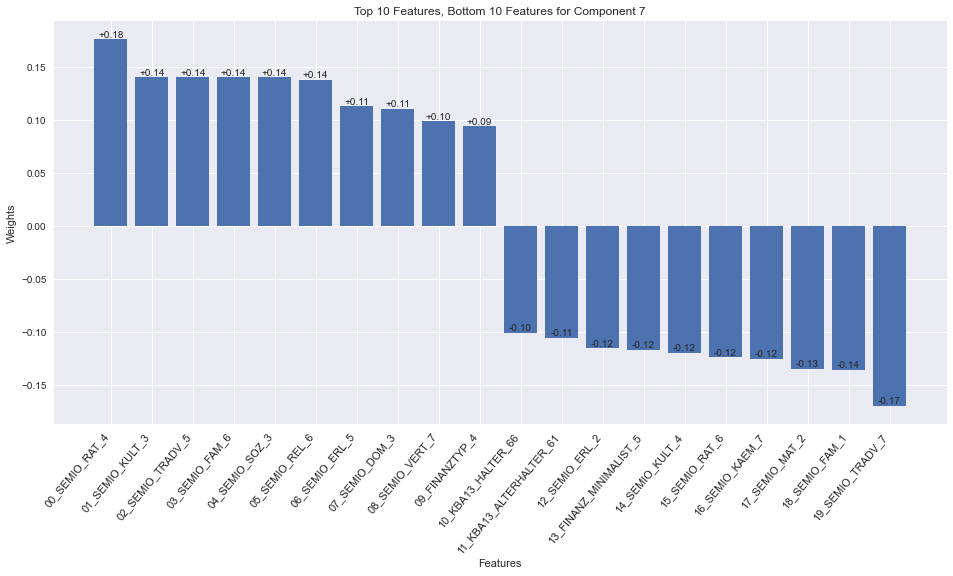

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


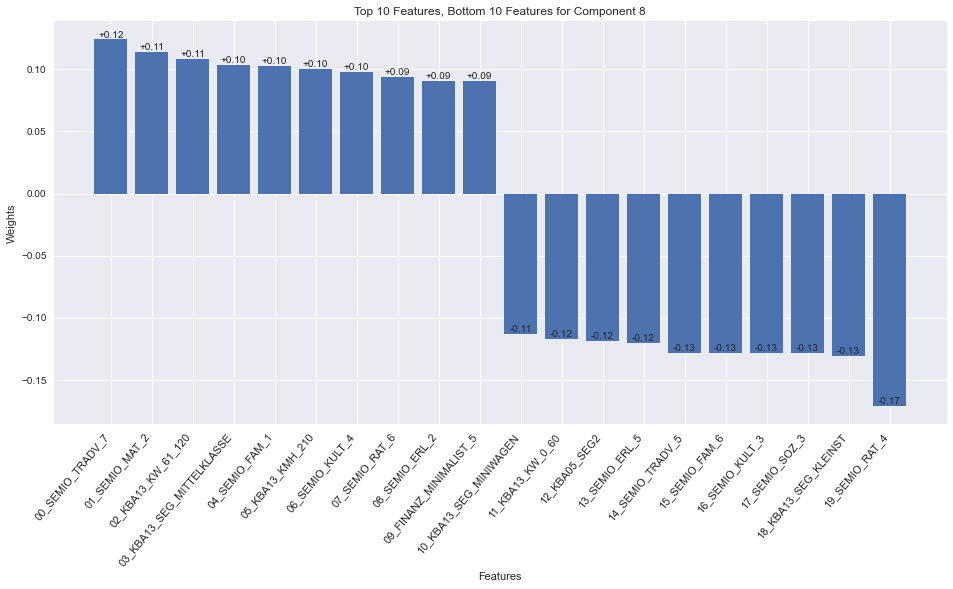

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664


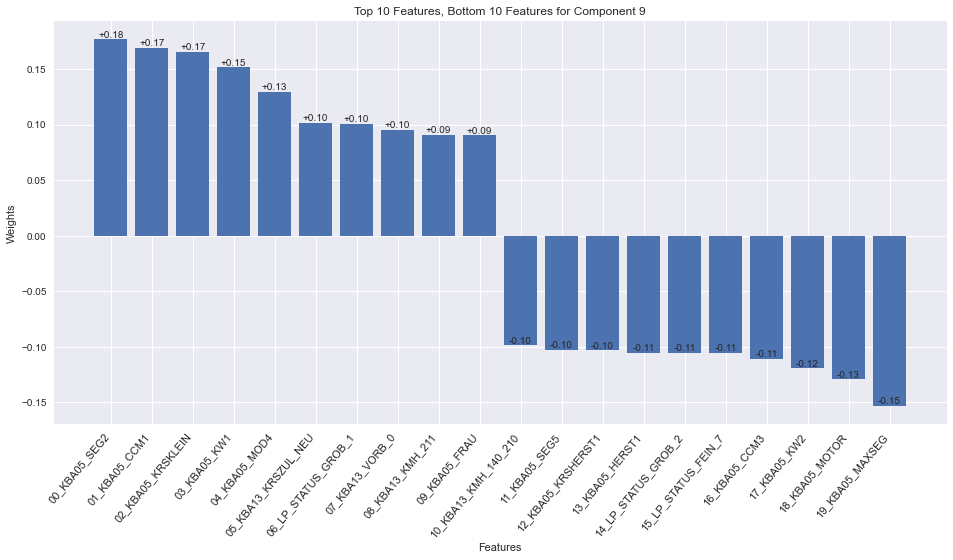

Dataset Shape:  (122636, 664)  No of Components:  80  No of Weights:  664
Principal Component 0 by Weigths - Top/Bottom 10 



,col_name,weight,desc,unknown_rate,unique
0,PLZ8_ANTG1,0.121253,number of 1-2 family houses in the PLZ8,0.277772,"[3.0, 2.0, 4.0, 1.0, nan]"
1,KBA05_ANTG1,0.120692,number of 1-2 family houses in the cell,0.295643,"[4.0, 0.0, 2.0, 1.0, 3.0]"
2,KBA13_ANTG1,0.120400,,0.269867,"[3.0, 2.0, 1.0, nan, 4.0]"
3,MOBI_RASTER,0.116218,,0.262901,"[3.0, 1.0, 5.0, 2.0, 6.0]"
4,PLZ8_BAUMAX_1,0.115976,most common building-type within the PLZ8,0.277772,"[1.0, 2.0, 4.0, nan, 5.0]"
5,CAMEO_DEU_2015,-0.118205,CAMEO_4.0: specific group,0.265510,"[5B, 9A, 3A, 3D, 4C]"
6,KBA13_ANTG3,-0.118218,,0.269867,"[1.0, 2.0, 0.0, 3.0, nan]"
7,HH_EINKOMMEN_SCORE,-0.118567,estimated household_net_income,0.016280,"[3.0, 6.0, 2.0, 4.0, 5.0]"
8,PLZ8_ANTG3,-0.119373,number of 6-10 family houses in the PLZ8,0.277772,"[1.0, 2.0, 0.0, 3.0, nan]"
9,LP_STATUS_GROB_3,-0.120968,social status rough,0.015523,"[3.0, 1.0, 5.0, 4.0, 2.0]"


Principal Component 1 by Weigths - Top/Bottom 10 



,col_name,weight,desc,unknown_rate,unique
0,CJT_TYP_1,0.153656,,0.015523,"[1.0, 3.0, 4.0, 2.0, 5.0]"
1,CJT_TYP_2,0.146044,,0.015523,"[1.0, 3.0, 4.0, 2.0, 5.0]"
2,PRAEGENDE_JUGENDJAHRE_7,0.110374,dominating movement in the person's youth (ava...,0.254057,"[3, 8, 13, 4, 5]"
3,RT_KEIN_ANREIZ,0.101685,,0.015523,"[1.0, 3.0, 4.0, 2.0, 5.0]"
4,RT_UEBERGROESSE,0.100142,,0.230655,"[1.0, 5.0, 4.0, 3.0, 2.0]"
5,FINANZ_SPARER_1,-0.129770,financial typology: money saver,0.000000,"[1, 3, 2, 5, 4]"
6,CJT_TYP_6,-0.130091,,0.015523,"[5.0, 4.0, 2.0, 3.0, 1.0]"
7,CJT_TYP_4,-0.133207,,0.015523,"[5.0, 4.0, 2.0, 3.0, 1.0]"
8,CJT_TYP_5,-0.135441,,0.015523,"[5.0, 3.0, 2.0, 1.0, 4.0]"
9,KOMBIALTER,-0.157912,,0.000000,"[4, 3, 1, 9, 2]"


Principal Component 2 by Weigths - Top/Bottom 10 



,col_name,weight,desc,unknown_rate,unique
0,KBA13_HERST_BMW_BENZ,0.171651,share of BMW & Mercedes Benz within the PLZ8,0.269867,"[3.0, 4.0, 2.0, 1.0, 5.0]"
1,KBA13_SEG_OBEREMITTELKLASSE,0.147123,share of upper middle class cars and upper cla...,0.269867,"[4.0, 5.0, 2.0, 3.0, nan]"
2,KBA13_MERCEDES,0.147018,share of MERCEDES within the PLZ8,0.269867,"[3.0, 4.0, 2.0, 1.0, nan]"
3,KBA13_BMW,0.142971,share of BMW within the PLZ8,0.269867,"[3.0, 2.0, 4.0, 1.0, 5.0]"
4,KBA13_SITZE_4,0.140929,number of cars with less than 5 seats in the PLZ8,0.269867,"[3.0, 2.0, 1.0, 4.0, 5.0]"
5,KBA13_KMH_180,-0.109323,share of cars with max speed between 110 km/h ...,0.269867,"[3.0, 2.0, 1.0, 4.0, nan]"
6,KBA13_HALTER_25,-0.114890,share of car owners between 21 and 25 within t...,0.269867,"[3.0, 1.0, 4.0, 2.0, 5.0]"
7,KBA13_SEG_KLEINWAGEN,-0.119146,share of small and very small cars (Ford Fiest...,0.269867,"[2.0, 4.0, 5.0, 3.0, 1.0]"
8,KBA13_KMH_140_210,-0.122628,share of cars with max speed between 140 and 2...,0.269867,"[3.0, 2.0, 1.0, 4.0, nan]"
9,KBA13_SITZE_5,-0.144164,number of cars with 5 seats in the PLZ8,0.269867,"[3.0, 2.0, 5.0, 4.0, 1.0]"


Principal Component 3 by Weigths - Top/Bottom 10 



,col_name,weight,desc,unknown_rate,unique
0,D19_GESAMT_ANZ_24,0.153084,,0.000000,"[2, 0, 3, 5, 4]"
1,D19_GESAMT_ANZ_12,0.143560,,0.000000,"[2, 0, 4, 1, 3]"
2,D19_VERSAND_ANZ_24,0.142156,,0.000000,"[2, 0, 3, 1, 4]"
3,D19_VERSAND_ANZ_12,0.130734,,0.000000,"[2, 0, 1, 4, 3]"
4,EWDICHTE,0.097456,density of inhabitants per square kilometer,0.263058,"[1.0, 5.0, 6.0, 2.0, 3.0]"
5,D19_VERSAND_ONLINE_DATUM,-0.138319,actuality of the last transaction for the segm...,0.000000,"[10, 5, 4, 2, 8]"
6,D19_GESAMT_ONLINE_DATUM,-0.144367,actuality of the last transaction with the com...,0.000000,"[10, 5, 4, 2, 8]"
7,VK_DISTANZ,-0.144999,,0.250352,"[2.0, 9.0, 1.0, 10.0, 7.0]"
8,D19_VERSAND_DATUM,-0.145922,actuality of the last transaction for the segm...,0.000000,"[5, 10, 4, 2, 9]"
9,D19_GESAMT_DATUM,-0.152310,actuality of the last transaction with the com...,0.000000,"[5, 10, 1, 2, 4]"


Principal Component 4 by Weigths - Top/Bottom 10 



,col_name,weight,desc,unknown_rate,unique
0,SEMIO_VERT_7,0.177602,affinity indicating in what way the person is ...,0.0,"[4, 5, 2, 6, 7]"
1,SEMIO_FAM_6,0.176112,affinity indicating in what way the person is ...,0.0,"[3, 5, 4, 1, 7]"
2,SEMIO_TRADV_5,0.176112,affinity indicating in what way the person is ...,0.0,"[3, 4, 2, 1, 5]"
3,SEMIO_SOZ_3,0.176112,affinity indicating in what way the person is ...,0.0,"[4, 6, 5, 2, 7]"
4,SEMIO_KULT_3,0.176112,affinity indicating in what way the person is ...,0.0,"[2, 5, 6, 1, 4]"
5,ALTERSKATEGORIE_GROB_1,-0.147734,age through prename analysis,0.0,"[4, 3, 1, 2, 9]"
6,SEMIO_KAEM_4,-0.151457,affinity indicating in what way the person is ...,0.0,"[5, 3, 2, 6, 4]"
7,SEMIO_KULT_6,-0.152441,affinity indicating in what way the person is ...,0.0,"[2, 5, 6, 1, 4]"
8,SEMIO_ERL_5,-0.186371,affinity indicating in what way the person is ...,0.0,"[7, 4, 3, 2, 1]"
9,ANREDE_KZ,-0.211465,gender,0.0,"[2, 1]"


2022-04-13 11:50:19.347674+00:00  General PCA -----------------------------------
new scaler
new pca model
General PCA (122636, 70)


In [11]:
# ---------------------------------------------------
# PCA - AZDIAS
# ---------------------------------------------------
# Apply PCA to the data.
# tried 30 but with 30 you will not reach 80% of the cumulated variance explaination
max_pca_no = 80    
# Apply feature scaling to the general population demographics data.
pca_gen, df_pca_gen, scaler_gen, models_dic_gen = \
        DfPca.do_pca(max_pca_no, df_imputed_gen, models_dic_gen, GC_PRINT)

# Reporting 
# Investigate the variance accounted for by each principal component.
# individual and cumulative explained variance 
if GC_PLOT == True:
    DfPca.plot_pca( pca_gen, df_imputed_gen, cols_dic_gen)  

# Re-apply PCA to the data while selecting for number of components to retain.
selected_pca_no = 70 # explains about 70% of the variance 
# Apply feature scaling to the general population demographics data.
models_dic_gen['m_scaler'] = ''
models_dic_gen['m_pca'] = ''
pca_gen, df_pca_gen, scaler_gen, models_dic_gen = \
        DfPca.do_pca(selected_pca_no, df_imputed_gen, models_dic_gen, GC_PRINT)
print('General PCA', df_pca_gen.shape)
if GC_PRINT == True:
    df_pca_gen.head()

<a id="GEN_KMEANS"></a>
## General Population - Unsupervised Learning - KMeans

> https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a <br>
Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

>The goal of kmeans is to group data points into distinct non-overlapping subgroups. It does a very good job when the clusters have a kind of spherical shapes. It also doesn’t learn the number of clusters from the data and requires it to be pre-defined. 

KMeans is a clustering technique which uses distances between the data points. Based on different central data points in the universe (the centroids), the method tries to collect all data points closest belonging to such a centroid. The number of centroid has to be chosen by you. You choose the number of centroides and therefore the number of clusters and the systems assign all data points which are closest to the centroid to that cluster based on a distance measure. Basically that is easier to understand. 

The elbow and the silhouette methods can support you in your decision. We have chosen here 20 clusters because at 20 the curve starts to flatten a little bit. Additionally the silhouette starts to decrease again. 

For our use case we will receive for every user a cluster number to which the method assigns our user. Such a cluster number could be a first indicator for our customer segmentation. Because it doesn't need qualified labels or responses from customers it is often used in such areas. 

Our data frame will be changed now again:  
- Input <br>
LNR, AGER_TYP, ALTERSCATEGORIE_FEIN, ALTER_KIND1, ALTER_KIND2, ...  366 columns

- After imputing and deleting columns <br>
LNR, AGER_TYP_0, AGER_TYP_1, AGER_TYP_2, ALTER_KIND1, ALTER_KIND3 ... 662 columns

- After principal component analysis (PCA)<br> 
LNR, PCA_1, PCA_2, PCA_3, PCA_4                               ...  70 columns

- KMeans adds now a cluster number to our columns<br>
LNR, PCA_1, PCA_2, PCA_3, PCA_4, .... cluster_no               ...  71 columns      

Later a part of the mailout data set has an information about whether a user has responded in an email compaign. This information can be used to check if one of the clusters detected has a higher rate of responses which can be used further to select people out of the general population belonging to the same cluster. 

- Basically we can join the data of our general population data set to the last data set with our cluster no so that a data set with 71 + 365 columns = 436 columns is created. <br>
LNR, PCA_1, PCA_2, ... cluster_no, AGER_TYP, ALTERSCATEGORIE_FEIN, ALTER_KIND1 ... 436 columns 

If a PCA component or a cluster is identified which is a candidate for the email campaign then the other features can be used to further restrict the sample by using some recommendation techniques like collaborative filtering based recommendation. 

2022-04-13 11:50:30.126200+00:00 KMeans 15 --------------------------------------
KMeans - Shape  (15, 70) 30462931.77974899 No of Labels:  122636  Score:  30462931.77974935  DataFrame:  (122636, 70)
2022-04-13 11:50:31.265284+00:00 KMeans 16 --------------------------------------
KMeans - Shape  (16, 70) 30193604.527442683 No of Labels:  122636  Score:  30193604.527442753  DataFrame:  (122636, 70)
2022-04-13 11:50:32.393320+00:00 KMeans 17 --------------------------------------
KMeans - Shape  (17, 70) 29983594.42677527 No of Labels:  122636  Score:  29983594.426774982  DataFrame:  (122636, 70)
2022-04-13 11:50:33.532356+00:00 KMeans 18 --------------------------------------
KMeans - Shape  (18, 70) 29683342.603242822 No of Labels:  122636  Score:  29683342.603242554  DataFrame:  (122636, 70)
2022-04-13 11:50:34.739358+00:00 KMeans 19 --------------------------------------
KMeans - Shape  (19, 70) 29623465.03919251 No of Labels:  122636  Score:  29623465.039192963  DataFrame:  (122636

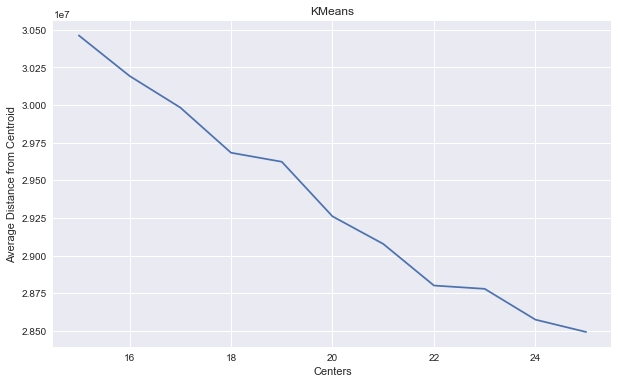

2022-04-13 11:50:44.244701+00:00 KMeans 20 --------------------------------------
KMeans - Shape  (20, 70) 29260401.81843941 No of Labels:  122636  Score:  29260401.818439513  DataFrame:  (122636, 70)


,cluster_no
df_id,
0,12
1,4
2,0
3,5
4,17


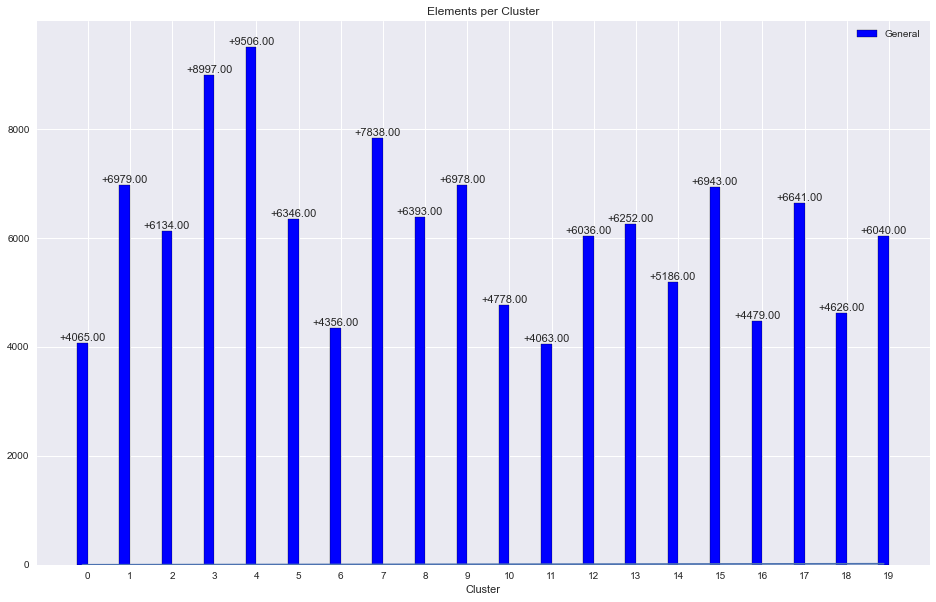

KMeans - inverse
                                Weight
LNR                     677089.944838
EINGEZOGENAM_HH_JAHR      1998.476540
INSERT_YEAR               1992.680411
MIN_GEBAEUDEJAHR          1992.503533
GEBURTSJAHR               1140.592918
KBA13_ANZAHL_PKW           705.062551
CAMEO_DEU_2015              38.591594
GEMEINDETYP                 27.278235
D19_VERSI_ONLINE_DATUM       9.985367
D19_TELKO_ONLINE_DATUM       9.980374


In [12]:
# ---------------------------------------------------
# KMeans - AZDIAS
# ---------------------------------------------------
# Execution 
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# 20 runs a long time so try the middle part of the recommended range 10-30 
cluster_nos = [15,16,17,18,19,20,21,22,23,24,25]  
o_df_kmeans = DfKmeans(GC_PRINT, GC_PLOT)   
k_gen_scores, k_gen_clusters, k_gen_centers, k_gen_labels = \
        o_df_kmeans.get_kmeans_scores( df_pca_gen, cluster_nos  )

# Reporting 
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
if GC_PLOT == True:
    o_df_kmeans.plot_kmeans_scores(cluster_nos, k_gen_scores)

# o_df_kmeans.get_kmeans_silhouette(df_pca_gen, 25)  

# Reporting 
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# the line decreases with some breaks f.i. at 16 and 20 clusters. But after the breaks it decreases further. At 20 clusters it decreases 
# first and then flattens at 21 clusters but increases again later at 24. It is not a clear elbough line with one break point.
# We stick to 20 because after that cluster no some diffent signals are given.   
# df_pca_gen.index

selected_cluster_no = 20
k_gen_score, k_gen_cluster, k_gen_center, k_gen_label = \
        o_df_kmeans.get_kmeans(df_pca_gen, selected_cluster_no )

df_cluster_gen=pd.DataFrame(k_gen_label,index=df_pca_gen.index, columns=['cluster_no'])
df_cluster_gen.index.name = 'df_id'
if GC_PRINT == True:
    display(df_cluster_gen.head())

if GC_PLOT == True:
    o_df_kmeans.plot_kmeans_cluster(k_gen_cluster, [], 'General', '')

df_kmeans_feat_gen = o_df_kmeans.get_kmeans_inverse(pca_gen, scaler_gen, 
                        k_gen_center[1], df_imputed_gen) 
if GC_PRINT == True:
    print('KMeans - inverse\n', df_kmeans_feat_gen.head(10))


<a id="CUST_PCA"></a>
## Customers - Unsupervised Learning - Principal Component Analysis (PCA)

The same procedure used for the general population is used here again for the customer data.

In [13]:
# ---------------------------------------------------
# PCA - CUSTOMERS
# ---------------------------------------------------
# Apply PCA to the data.
pca_cust, df_pca_cust, scaler_cust, models_dic_gen = \
        DfPca.do_pca(selected_pca_no, df_imputed_cust, models_dic_gen, GC_PRINT )

2022-04-13 11:50:46.116416+00:00  General PCA -----------------------------------
old scaler
old pca model


<a id="CUST_KMEANS"></a>
## Customers - Unsupervised Learning - KMeans

The same procedure used for the general population is used here again for the customer data.

Comparing the clusters created for the general population and the clusters of existing customers, the general population is stronger in some clusters like in 9 and 10. In both clusters the customers seem underrepresented which could indicate that they are not interested in the products of the company.  

2022-04-13 11:50:46.590439+00:00 KMeans 20 --------------------------------------
KMeans - Shape  (20, 70) 4438357.693687357 No of Labels:  28866  Score:  4438357.693687364  DataFrame:  (28866, 70)


,cluster_no
df_id,
0,12
1,10
2,9
3,19
4,2


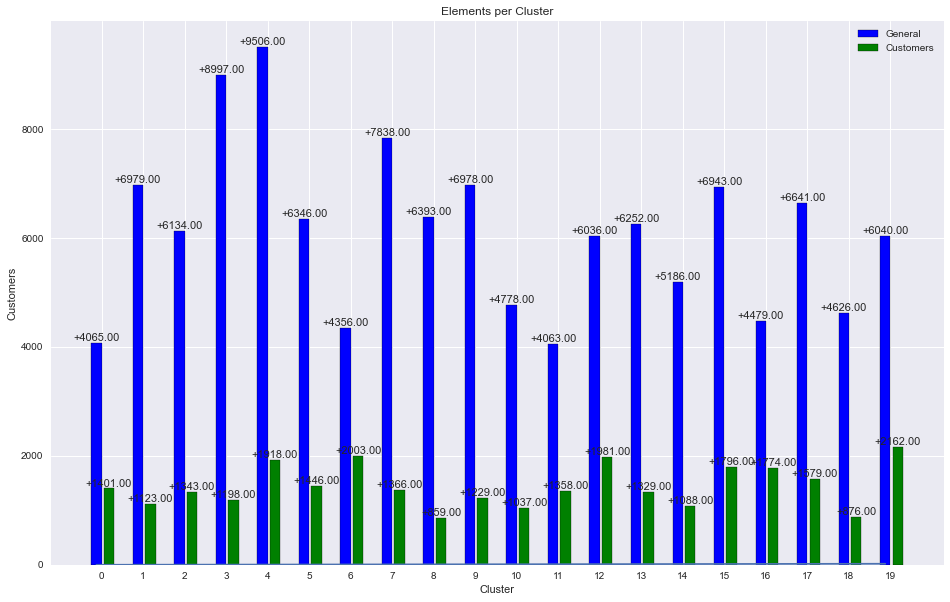

KMeans - inverse
                                    Weight
LNR                         590224.772771
EINGEZOGENAM_HH_JAHR          2000.289372
INSERT_YEAR                   1994.343833
MIN_GEBAEUDEJAHR              1993.581239
GEBURTSJAHR                   1178.882906
KBA13_ANZAHL_PKW               421.066590
CAMEO_DEU_2015                  69.828558
GEMEINDETYP                     14.619513
ANZ_HAUSHALTE_AKTIV             11.892959
ANZ_STATISTISCHE_HAUSHALTE      10.613992


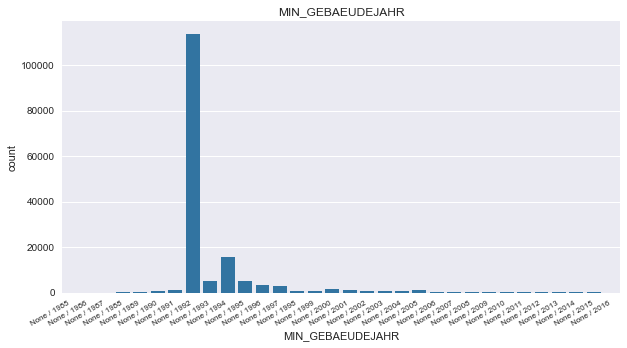

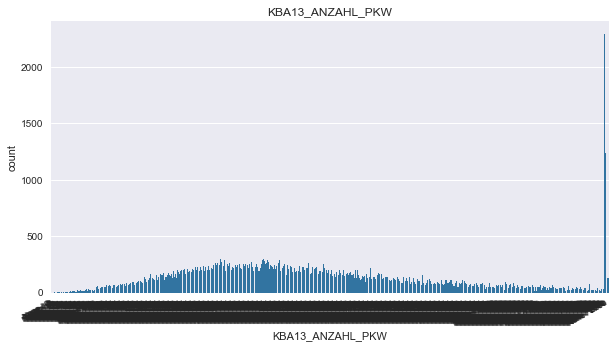

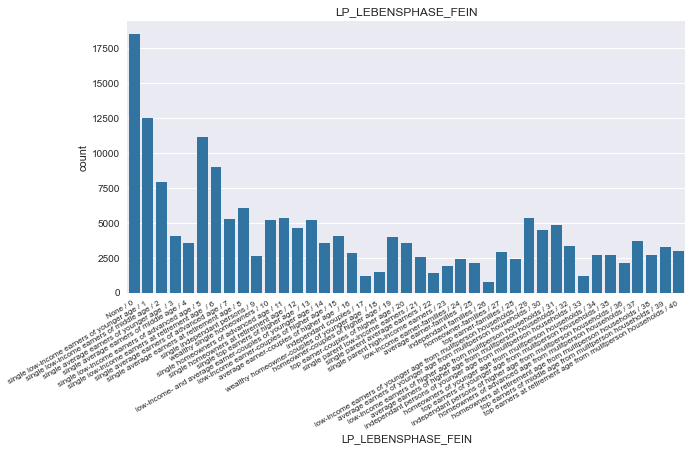

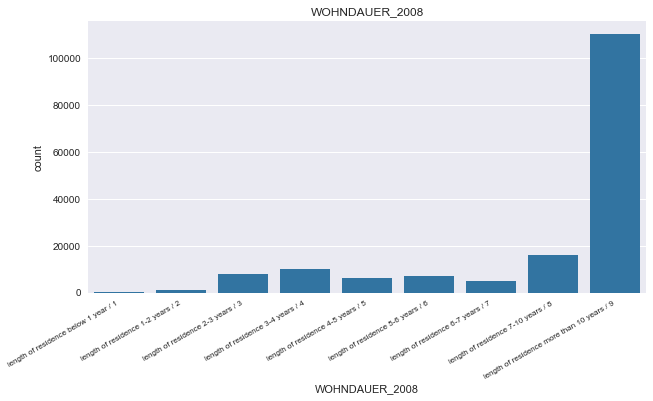

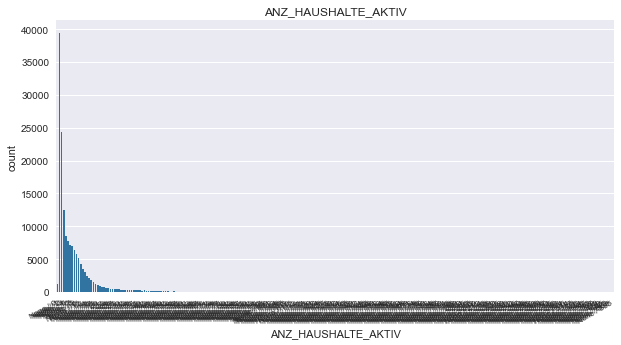

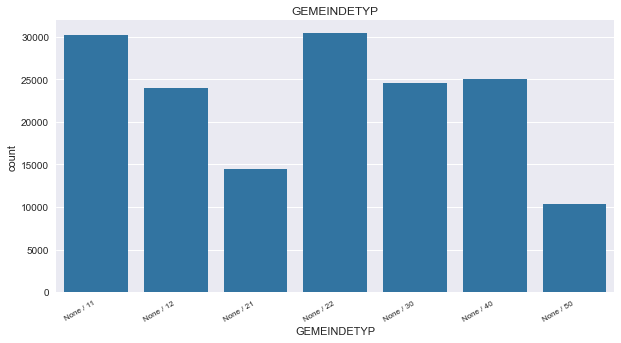

In [14]:
# ---------------------------------------------------
# KMeans -  CUSTOMERS
# ---------------------------------------------------
k_cust_score, k_cust_cluster, k_cust_center, k_cust_label = \
        o_df_kmeans.get_kmeans(df_pca_cust, selected_cluster_no )

df_cluster_cust=pd.DataFrame(k_cust_label,index=df_pca_cust.index, columns=['cluster_no'])
df_cluster_cust.index.name = 'df_id'
if GC_PRINT == True:
    display(df_cluster_cust.head())

if GC_PLOT == True:
    o_df_kmeans.plot_kmeans_cluster(k_gen_cluster, k_cust_cluster, 'General', 'Customers')

df_kmeans_feat_cust = o_df_kmeans.get_kmeans_inverse(pca_gen, scaler_gen, 
                        k_cust_center[9], df_imputed_cust) 
if GC_PRINT == True:
    print('KMeans - inverse\n', df_kmeans_feat_cust.head(10))

# distribution of the features dominant in the selected clusters for over-/underrepresentations 
# if GC_PLOT == False:
if GC_PLOT == True:
    cols = ['MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW', 'LP_LEBENSPHASE_FEIN', 'WOHNDAUER_2008',          
                'ANZ_HAUSHALTE_AKTIV', 'GEMEINDETYP']
    o_df_stat.plot_cols(azdias, cols, master_dic_gen)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<a id="MAILOUT_LOAD_DATA"></a>
## Mailout - Preprocessing - Load the Data 
In the mailout data set is a reponse column which now can be used to check if our PCA components and our cluster numbers are useful candidates for making predictions about new customers.

After loading the data in a 1st step the response columns is saved separately and then dropped from the data set.

In [15]:
# ---------------------------------------------------
# load data - MAILOUT_TRAIN
# ---------------------------------------------------
mailout_train = o_df_proj.get_data_train( )

# Reporting 
o_df_stat = DfStat(mailout_train, cols_dic_gen) 
if GC_PRINT == True:
    o_df_stat.print_no( )  

o_df_proj.do_response(mailout_train)

if GC_PRINT == True:
    df_check_gen, df_check_train = o_df_stat.print_colcompare(azdias, mailout_train, False) 
    print('Gen/Train', df_check_gen.shape, df_check_train.shape)

2022-04-13 11:52:09.812106+00:00 Load Mailout Train Data ------------------------
--------------------------------------------------
Numbers  2022-04-13 11:52:11.394103+00:00
--------------------------------------------------
Number of rows 42,962 and columns 367
Number of NaN values in our DataFrame: 2217179
Number of columns with NaN values: 273
Number of rows with NaN columns > 36: 8770
response cnt 532
response rate 0.012383036171500396
response values
 0    42430
1      532
Name: RESPONSE, dtype: int64


,RESPONSE,LNR
0,0,1763
1,0,1771
2,0,1776
3,0,1460
4,0,1783


Gen/Customer (178244, 366) (42962, 366)
Gen/Train (178244, 366) (42962, 366)


In [16]:
# print(mailout_train['CAMEO_DEUG_2015'].unique())
# print(mailout_train['CAMEO_DEUG_2015'].dtype)
# mailout_train['CAMEO_DEUG_2015'].replace(to_replace={'1': 1, '2': 2, '3': 3, 
#                   '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}, inplace = True)
        

## Mailout - Preprocessing - Clean Data

The same procedure used for the general population is used here again for the mailout data. 

Our central data dictionary is used to drop the same columns as in our general population data set to make them comparable.

Because of the onehot encoding it has to be checked again if the column numbers are the same. Because mailout data set could contain other categories than in the original data set the onehot encoding could create different columns. Our COLCOMPARE method will harmonize the columns again.


2022-04-13 11:52:11.844113+00:00  Preprocessing - Remove Nan Colums -------------
Columns to delete - skip=True
 (19, 17) 



,col_name,type,datatype,inttype,skip,desc,nan_cnt,nan_ratio,unique_cnt,unique,unknown,unknown_cnt,unknown_rate,unknown_skip,unknown_list,skip_reason,not_in_dic
AGER_TYP,AGER_TYP,int64,categorical,True,True,best-ager typology,0,0.000000,5,"[-1, 2, 1, 3, 0]",-1,17963,0.418114,True,"[-1, nan]",high rate of NaNs,
ALTER_KIND1,ALTER_KIND1,float64,,True,True,,161993,0.908827,17,"[nan, 11.0, 8.0, 13.0, 17.0]",,40974,0.953727,True,[nan],high rate of NaNs,X
ALTER_KIND2,ALTER_KIND2,float64,,True,True,,172294,0.966619,16,"[nan, 15.0, 16.0, 11.0, 10.0]",,42206,0.982403,True,[nan],high rate of NaNs,X
ALTER_KIND3,ALTER_KIND3,float64,,True,True,,177002,0.993032,14,"[nan, 16.0, 13.0, 17.0, 15.0]",,42788,0.995950,True,[nan],high rate of NaNs,X
ALTER_KIND4,ALTER_KIND4,float64,,True,True,,178007,0.998670,11,"[nan, 13.0, 15.0, 16.0, 17.0]",,42921,0.999046,True,[nan],high rate of NaNs,X
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,float64,,True,True,,52409,0.294030,25,"[nan, 14.0, 16.0, 10.0, 0.0]",,8155,0.189819,True,[nan],high rate of NaNs,X
D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,10,"[0.0, nan, 10.0, 9.0, 7.0]",,7584,0.176528,True,[nan],high rate of NaNs,
D19_GESAMT_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,11,"[0.0, 10.0, 4.0, nan, 5.0]",,7584,0.176528,True,[nan],high rate of NaNs,
D19_KONSUMTYP,D19_KONSUMTYP,float64,categorical,True,True,consumption type,51321,0.287926,7,"[2.0, 9.0, 6.0, 1.0, nan]",,7584,0.176528,True,[nan],high rate of NaNs,
D19_LETZTER_KAUF_BRANCHE,D19_LETZTER_KAUF_BRANCHE,object,categorial,False,True,,51321,0.287926,35,"[D19_TECHNIK, D19_UNBEKANNT, D19_SCHUHE, D19_B...",,7584,0.176528,True,[nan],high rate of NaNs,X


meplot True


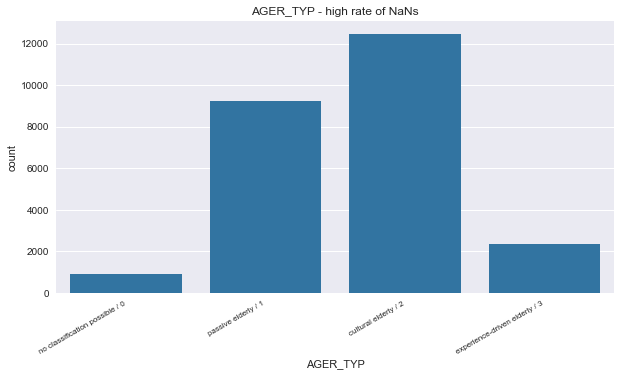

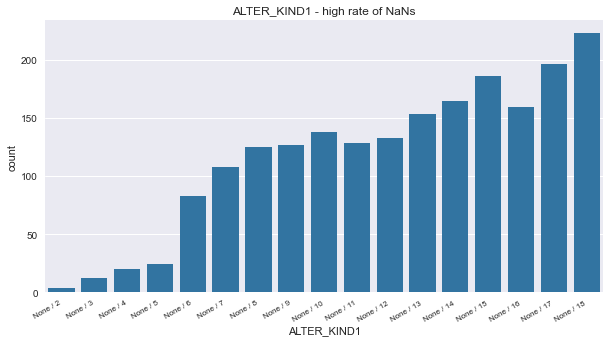

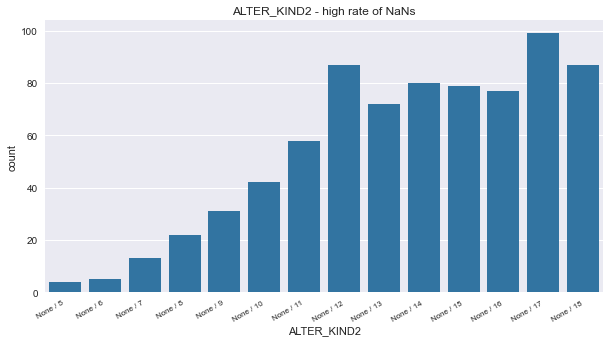

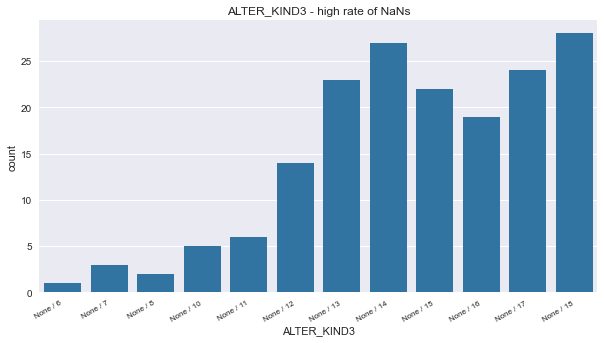

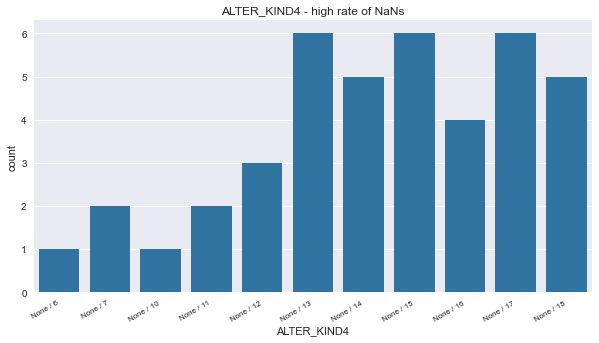

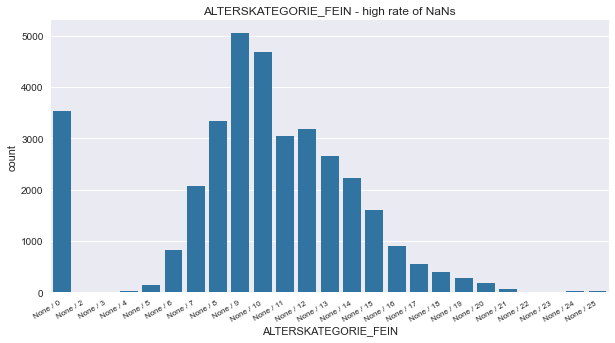

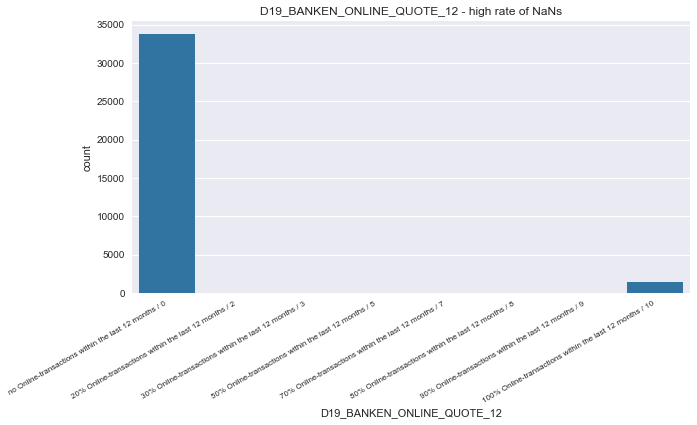

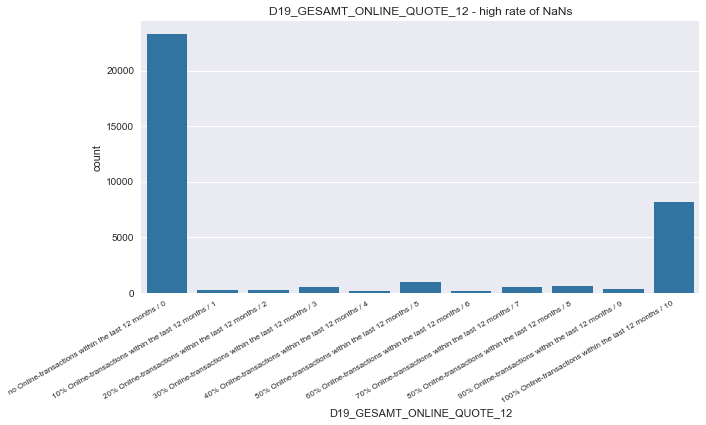

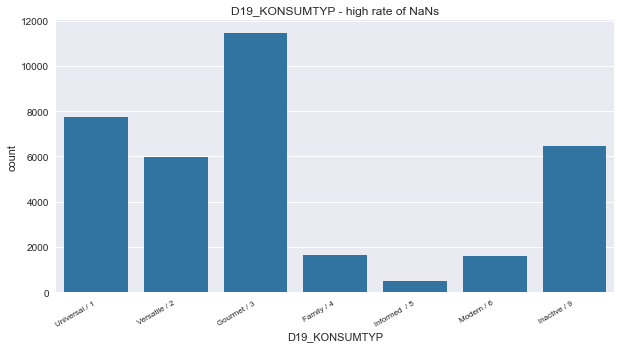

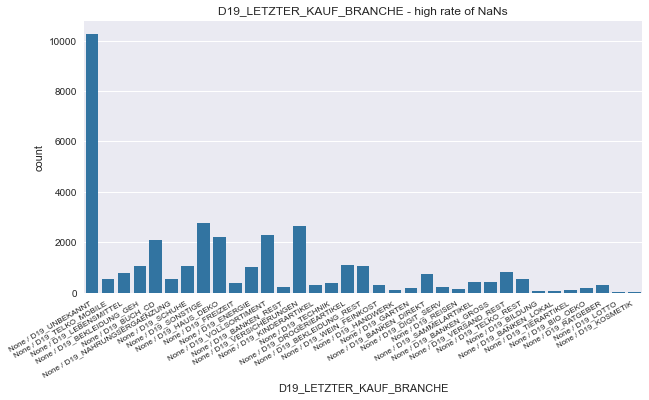

remove AGER_TYP
remove ALTER_KIND1
remove ALTER_KIND2
remove ALTER_KIND3
remove ALTER_KIND4
remove ALTERSKATEGORIE_FEIN
remove D19_BANKEN_ONLINE_QUOTE_12
remove D19_GESAMT_ONLINE_QUOTE_12
remove D19_KONSUMTYP
remove D19_LETZTER_KAUF_BRANCHE
remove D19_LOTTO
remove D19_SOZIALES
remove D19_TELKO_ONLINE_QUOTE_12
remove D19_VERSAND_ONLINE_QUOTE_12
remove D19_VERSI_ONLINE_QUOTE_12
remove EXTSEL992
remove KBA05_BAUMAX
remove KK_KUNDENTYP
remove TITEL_KZ
DataFrame after Column Deletion: (42962, 347)
2022-04-13 11:52:24.509851+00:00  Preprocessing - Remove Nan Rows ---------------
Rows NaN:  10  Rows not-Nan:  42952
2022-04-13 11:52:24.980853+00:00  Feature Reencoding-----------------------------
OST_WEST_KZ --------------------
old ['W' 'O' nan]
new [ 0.  1. nan]
CAMEO_DEUG_2015
old [5.0 2.0 7.0 4.0 nan 3.0 6.0 1.0 8.0 9.0 '4' '6' '2' '9' '8' '7' '3' '1'
 '5' 'X']
new [ 5.  2.  7.  4. nan  3.  6.  1.  8.  9.]
CAMEO_DEU_2015 --------------------
old ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A'

In [17]:
# ---------------------------------------------------
# clean data - MAILOUT_TRAIN
# ---------------------------------------------------
df_clean_train, cols_dic_gen, models_dic_gen, GC_MAX_NAN_COLUMNS = \
    o_df_proj.clean_data(mailout_train, cols_dic_gen, GC_MAX_NAN_COLUMNS)
print('Mailout Train shape - cleaned', df_clean_train.shape)

# compare the columns of the general and the customer dataset 
df_imputed_gen, df_clean_train = o_df_stat.print_colcompare(df_imputed_gen, df_clean_train, 
                                                            True, p_print=GC_PRINT) 
print('Gen imputed /Train cleaned', df_imputed_gen.shape, df_clean_train.shape) 

## Mailout - Preprocessing - Imputing
Nothing new here as the same procedure used for the general population is used here again. The column compare is just a check to be sure that the column numbers haven't changed. 

In [18]:
# ---------------------------------------------------
# imputing - MAILOUT_TRAIN
# --------------------------------------------------- 
df_imputed_train,  models_dic_gen = DfDataPrep01.do_imputing_mean(
    df_clean_train, 'mean', models_dic_gen ) 

# Reporting 
# compare the columns of the general and the customer dataset 
if GC_PRINT == True:
    df_check_1, df_check_2 = o_df_stat.print_colcompare(df_imputed_gen, df_imputed_train, False) 
    print('Gen/Customer - imputed', df_check_1.shape, df_check_2.shape)

# exits every response record still in the cleaned dataframe? 
# if GC_PRINT == True:
#     df_filter = o_df_proj.mailout_response_train['LNR'].isin(df_clean_train['LNR'])
#     df_check = pd.DataFrame(o_df_proj.mailout_response_train[['RESPONSE']][df_filter])
#     print('values\n', df_check.value_counts())
#     print('response / clean', o_df_proj.mailout_response_train.shape, df_clean_train.shape)

2022-04-13 11:52:28.805863+00:00  feature imputing ------------------------------
Gen/Customer (122636, 664) (42952, 664)
Gen/Customer - imputed (122636, 664) (42952, 664)


<a id="MAILOUT_PCA"></a>
## Mailout - Unsupervised Learning - Principal Component Analysis (PCA)

The old scaler and the old pca model are used here again which are stored in our model dictionary for the further usage here.

In [19]:
# ---------------------------------------------------
# PCA - MAILOUT_TRAIN
# ---------------------------------------------------
# Apply PCA to the data.
pca_train, df_pca_train, scaler_train, models_dic_gen = \
        DfPca.do_pca(selected_pca_no, df_imputed_train, models_dic_gen, GC_PRINT )

2022-04-13 11:52:33.265975+00:00  General PCA -----------------------------------
old scaler
old pca model


<a id="MAILOUT_KMEANS"></a>
## Mailout - Unsupervised Learning - KMeans

The same procedure used for the general population is used here again for the mailout data.

Now the clusters for the general population can be compared to the clusters got for the mail out data set. Because the later contains a response column we can now have a look if one of the clusters has a higher percentage of response. Such a cluster would be a candidate for further email compaigns because the people seems to have similar features. 

In [20]:
# ---------------------------------------------------
# KMeans - MAILOUT_TRAIN
# ---------------------------------------------------
k_train_score, k_train_cluster, k_train_center, k_train_label = \
        o_df_kmeans.get_kmeans(df_pca_train, selected_cluster_no )

2022-04-13 11:52:33.917028+00:00 KMeans 20 --------------------------------------
KMeans - Shape  (20, 70) 5644848.8016458005 No of Labels:  42952  Score:  5644848.801645855  DataFrame:  (42952, 70)


unique
 0    42420
1      532
Name: RESPONSE, dtype: int64
nan cnt 0
nan rate 0.0
Mailout Cluster Shape (42952, 73)
cluster train (42952, 73)


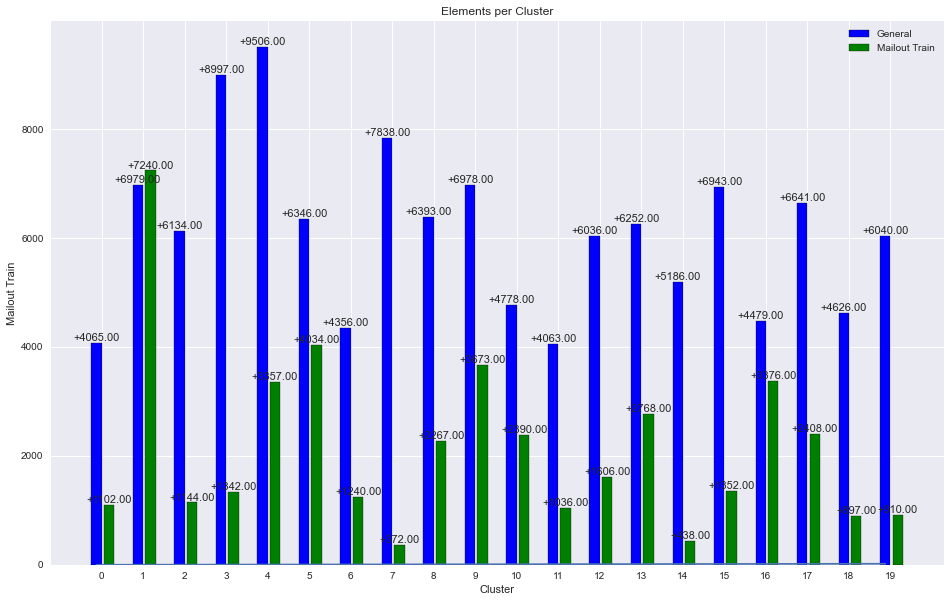

,cnt_gen,cnt_train,cnt_diff
0,4065,1102,2963
1,6979,7240,-261
2,6134,1144,4990
3,8997,1342,7655
4,9506,3357,6149
5,6346,4034,2312
6,4356,1240,3116
7,7838,372,7466
8,6393,2267,4126
9,6978,3673,3305


In [21]:
# Cluster
# ---------------------------------------------------
df_lnr_train = pd.DataFrame(data={'LNR' : o_df_proj.mailout_response_train['LNR'], 
                                  'RESPONSE' : o_df_proj.mailout_response_train['RESPONSE']})
df_cluster_train, df_lnr_train = o_df_proj.do_cluster(df_clean_train, df_pca_train, 
                                    k_train_label, df_lnr_train, 'PRINT') 
print('cluster train', df_cluster_train.shape)

# Reporting 
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
if GC_PLOT == True:
    o_df_kmeans.plot_kmeans_cluster(k_gen_cluster, k_train_cluster, 'General', 
                                    'Mailout Train')
if GC_PRINT == True:
    df_check = pd.DataFrame()
    df_check['cnt_gen'] = pd.Series(k_gen_cluster[:,1])
    df_check['cnt_train'] = pd.Series(k_train_cluster[:,1])
    df_check['cnt_diff'] = df_check['cnt_gen'] - df_check['cnt_train']
    display(df_check.head(20)) 


fi_me = 'E' # E=Export, I=Import
if fi_me == 'E':
    fi_cluster_train = open("./data/df_cluster_train.pickle","wb")
    pickle.dump(df_cluster_train, fi_cluster_train)
    fi_cluster_train.close()
else:
    fi_cluster_train = open("./data/df_cluster_train.pickle","rb")
    df_cluster_train = pickle.load(fi_cluster_train)

sum (20, 6)


,cnt_0,cnt_1,sum,ratio_sum,ratio_1,sum_1_cum
cluster_no,,,,,,
17,2360,48,2408,0.019934,0.090226,0.019934
9,3616,57,3673,0.015519,0.107143,0.035452
6,1221,19,1240,0.015323,0.035714,0.050775
4,3308,49,3357,0.014596,0.092105,0.065371
0,1088,14,1102,0.012704,0.026316,0.078075
15,1335,17,1352,0.012574,0.031955,0.090649
1,7151,89,7240,0.012293,0.167293,0.102942
16,3335,41,3376,0.012145,0.077068,0.115087
5,3987,47,4034,0.011651,0.088346,0.126738


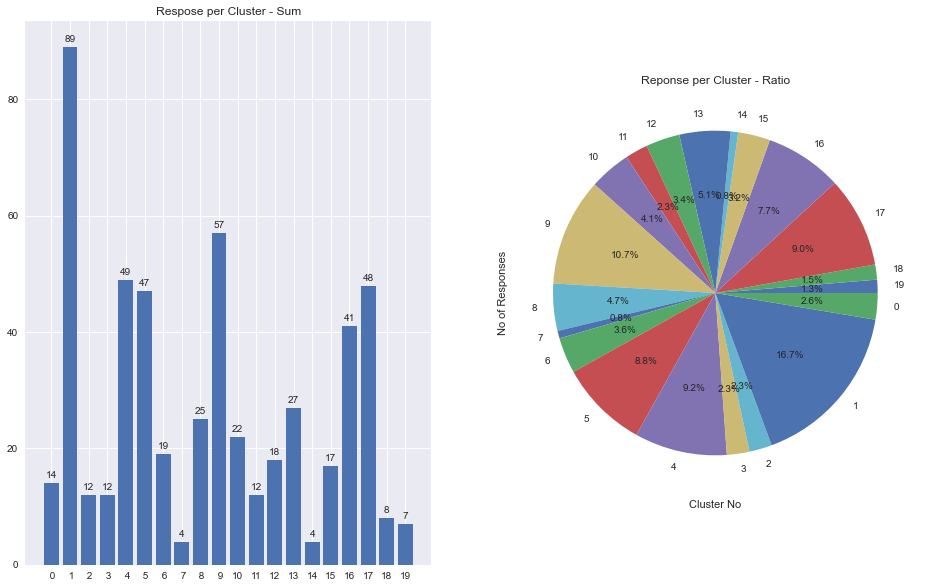

In [22]:
# some info about the clusters 
o_df_stat.print_cluster_sum(df_cluster_train)
o_df_stat.plot_cluster_sum(df_cluster_train)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [23]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

<a id="MAILOUT_SL_BUILD"></a>
## Mailout - Supervised Learning - Modelbuilding 

### Models 

The following models are used: 
- Logistic Regression
- RandomForrest 
- BalancedRandomForest
- AGBoost

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
resample
https://vitalflux.com/handling-class-imbalance-sklearn-resample-python/

Because our data set is heavily unbalanced (a response of 1 appears only in about 1% of the cases), the evaluation of the model has to be done carefully. 

### Evaluation - Confusion Matrix and AUC 

One way to evaluate the model is to use a confusion matrix and related terms from there (sensivity and specificity). 
The target is that our model should classify reponses to the email campaign well even if some of the non responses are misclassified. A high accuracy rate is not enough here. If only 1% respond and our  model classifies all as non responds (100%) then the model has still a high accuracy rate of 99%. 

The kaggle competition uses the AUC (area under curve) metric to evaluate the model. The closer the AUC is to 1, the better the model. The curve is the ROC curve (receiver operating characteristic”) which measures the sensivity on the y axis and the specifity on the x axis. 
> https://www.statology.org/auc-in-python/ <br> 
- Sensitivity: The probability that the model predicts a positive outcome for an observation when indeed the outcome is positive. This is also called the “true positive rate.”
- Specificity: The probability that the model predicts a negative outcome for an observation when indeed the outcome is negative. This is also called the “true negative rate.”<br>

A high value near to 1 would classify correctly many positive responses without misclassifying many negative responses as positive. That would reduce including email recipients in the campaign which would not answer. 

### Oversampling 

To do something against the unbalanced data set oversampling is used based on the resample method of the sklearn module. For the minority sample additional records are genereated which are added to our data set.The oversampling is done during the splitting of the data in train and test data. To doesn't spoil the test data, first the normal splitting is done and then afterwards the train data is oversampled. 

### KFolds 

Another method against unbalanced data is the usage of the RepeatedStratifiedKFold 

> https://scikit-learn.org/stable/modules/cross_validation.html#repeated-k-fold<br>
Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.


The KFold method by itself can be used to split the data into train and test sets by dividing the data into k consecutive folds. Each fold is then used for the validation while the remaining folds are put into the training set. A similar mechanism is used for bagging.   

### RandomizedSearchCV

The sklearn docu states in short: Randomized search on hyper parameters, that means the method tries to fit models with different hyper parameters and returns the result based on the best model regarding a predefined metric which is in our case 'ROC_AUC'. 

The parameters of the estimators used to apply these methods are optimized by a cross-validated search over parameter settings.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The randomized version is used out of perfomance reasons. 

The process in our case is therefore: 
- Split the data into test and train data by using oversampling 
- Create the KFold object to determine how many folds and repetitions should be done
- For every model ( Logistic Regression, Random Forest, BalancedRandomForest, Agboost)
    - Create the RandomizedSearchCV object with certain hyper parameters
    - Train the model by using the RandomizedSearchCV object
- Check the results to determine which model should be used to make the predictions on new data. 

For the BalancedRandomForest estimator the data was not oversampled because the module handles that directly.


### Results 

For every estimator the following was displayed: 
- confusion matrix (printed and ploted)
- ROC curve with included AUC score 
- Accurracy, Mean Score, Mean Fit Time, ROC AUCH auccuracy
- Best Parameters

The disappointing part of the work was, that the AUC score doesn't exceed the 0.53 value which means that the prediction is not really good and not much above the 50% chance you would expect in a 0/1 sampling. 

It was tried to use other parameters or doesn't use any parameter at all, f.i. for the logistic regression example. Even without the parameters the default parameters values seems to do a good job because the score was just 1 point higher with the parameters.

KFolds, standardizing, eliminating of sparse columns, oversampling, different hyper parameters - all that should do something the the data quality and the machine learning process. But here without any success. 

Storing intermediate results as pickle files doesn't help much because the main runtime is used for the model training so that further playing around with different hyper parameters are not really efficient. 

It would be easy to add new estimators to the class framework used but that wasn't practiced because of the long runtimes which is even longer in the Udacity workspace than on the local notebook.

In [24]:
# Balancing ratio 
df_check = df_cluster_train.iloc[:,-2].value_counts(normalize=True)
df_check


0    0.987614
1    0.012386
Name: RESPONSE, dtype: float64

2022-04-13 11:52:36.721275+00:00 LOGREG build -----------------------------------
x_train / x_test:  (34361, 71) (8591, 71) 0.2500218270713891
y_train / y_test:  (34361,) (8591,) 0.2500218270713891
before 42952 42952
before 34361 34361
after 42952 42952
after 67874 67874
2022-04-13 11:52:36.948280+00:00 LOGREG fit -------------------------------------
2022-04-13 11:54:02.216252+00:00 LOGREG predict ---------------------------------
2022-04-13 11:54:02.227252+00:00 LOGREG result ----------------------------------


2022-04-13 11:54:02.227252+00:00 Logistic Regression ----------------------------
Labels: [0 1]
Confusion Matrix: 
 [[5305 3178]
 [  66   42]]


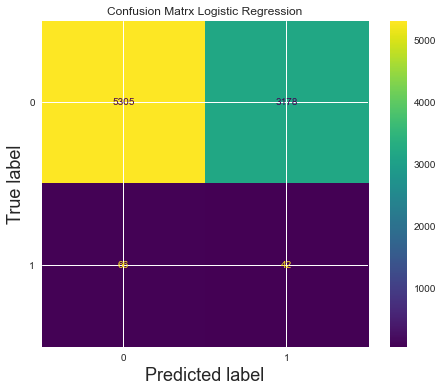

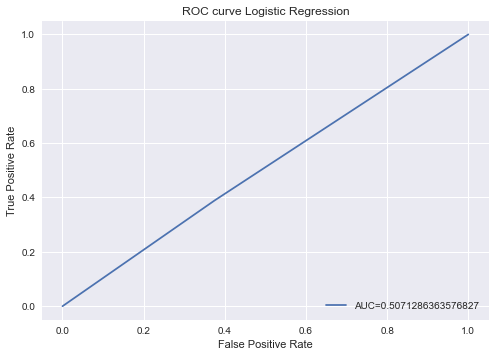

Accuracy        : 0.6223955302060296
Mean Score      : nan
Mean Fit Time   : 0.8055133891105651
ROC AUC accuracy: 0.51:
Best Parameters :
 {'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__max_iter': 1000, 'clf__C': 0.1}
2022-04-13 11:54:02.752342+00:00 RANFOR build -----------------------------------
ran1 True 42952 42952
ran2 True <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
x_train / x_test:  (34361, 71) (8591, 71) 0.2500218270713891
y_train / y_test:  (34361,) (8591,) 0.2500218270713891
before 42952 42952
before 34361 34361
after 42952 42952
after 67874 67874
2022-04-13 11:54:02.982512+00:00 RANFOR fit -------------------------------------
2022-04-13 13:46:56.652872+00:00 RANFOR predict ---------------------------------
2022-04-13 13:46:56.810878+00:00 RANFOR result ----------------------------------


2022-04-13 13:46:56.810878+00:00 RandomForest -----------------------------------
Labels: [0 1]
Confusion Matrix: 
 [[8471   12]
 [ 108    0]]


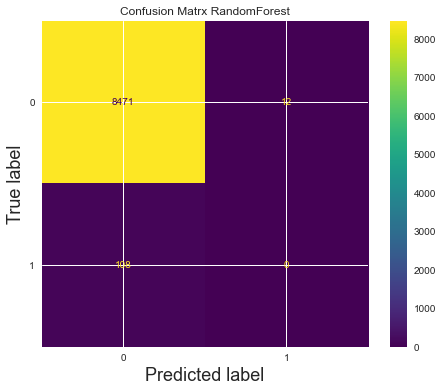

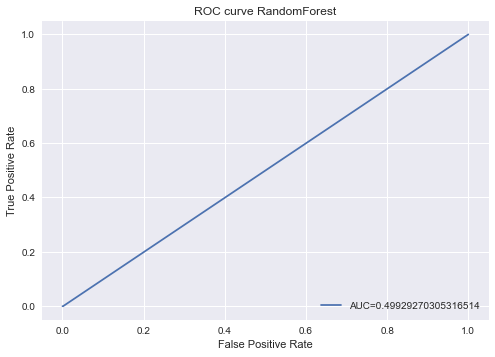

Accuracy        : 0.9860318938423932
Mean Score      : 0.9990537660105933
Mean Fit Time   : 65.08587402105331
ROC AUC accuracy: 0.50:
Best Parameters :
 {'clf__n_estimators': 62, 'clf__min_samples_split': 7, 'clf__max_features': 29, 'clf__criterion': 'entropy'}
2022-04-13 13:46:57.404866+00:00 BALRANFOR build --------------------------------
x_train / x_test:  (34361, 71) (8591, 71) 0.2500218270713891
y_train / y_test:  (34361,) (8591,) 0.2500218270713891
2022-04-13 13:46:57.467879+00:00 BALRANFOR fit ----------------------------------
2022-04-13 13:49:48.937346+00:00 BALRANFOR predict ------------------------------
2022-04-13 13:49:48.989342+00:00 BALRANFOR result -------------------------------


2022-04-13 13:49:48.989342+00:00 BalancedRandomForest ---------------------------
Labels: [0 1]
Confusion Matrix: 
 [[7968  515]
 [  96   12]]


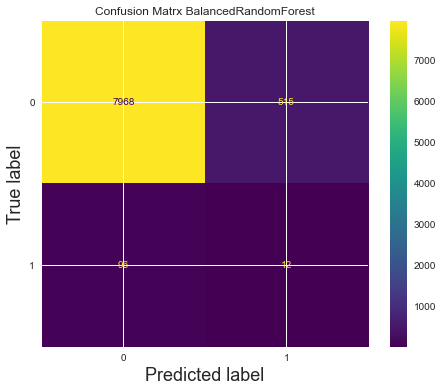

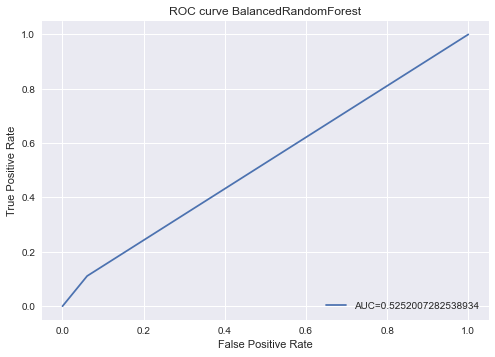

Accuracy        : 0.928879059480852
Mean Score      : 0.5094525631089177
Mean Fit Time   : 1.4125010085105896
ROC AUC accuracy: 0.53:
Best Parameters :
 {'clf__sampling_strategy': 0.4, 'clf__n_estimators': 20, 'clf__min_samples_split': 10, 'clf__max_features': 13, 'clf__criterion': 'entropy'}
2022-04-13 13:49:49.544890+00:00 XGB build --------------------------------------
x_train / x_test:  (34361, 71) (8591, 71) 0.2500218270713891
y_train / y_test:  (34361,) (8591,) 0.2500218270713891
before 42952 42952
before 34361 34361
after 42952 42952
after 67874 67874
2022-04-13 13:49:49.770883+00:00 XGB fit ----------------------------------------
2022-04-13 14:54:05.706639+00:00 XGB predict ------------------------------------
2022-04-13 14:54:05.805799+00:00 XGB result -------------------------------------


2022-04-13 14:54:05.805799+00:00 XGB --------------------------------------------
Labels: [0 1]
Confusion Matrix: 
 [[8462   21]
 [ 108    0]]


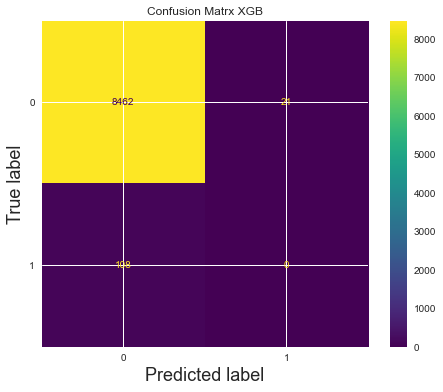

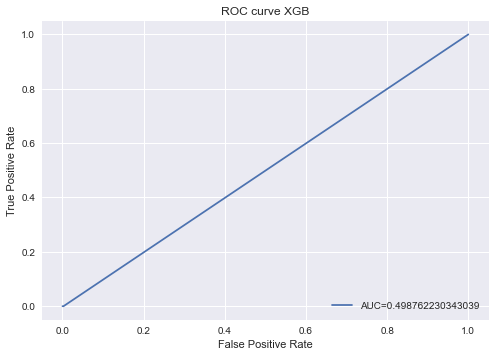

Accuracy        : 0.9849842858805727
Mean Score      : 0.997466709893841
Mean Fit Time   : 41.78832736545139
ROC AUC accuracy: 0.50:
Best Parameters :
 {'clf__objective': 'binary:logistic', 'clf__n_estimators': 250, 'clf__max_depth': 9, 'clf__learning_rate': 0.9, 'clf__eval_metric': 'rmse'}


,accuracy,auccuracy_roc_auc,mean_score,mean_fit_time,model
LOGREG,0.622396,0.507129,NaN,0.805513,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
RANFOR,0.986032,0.499293,0.999054,65.085874,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
BALRANFOR,0.928879,0.525201,0.509453,1.412501,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...
XGB,0.984984,0.498762,0.997467,41.788327,RandomizedSearchCV(cv=RepeatedStratifiedKFold(...


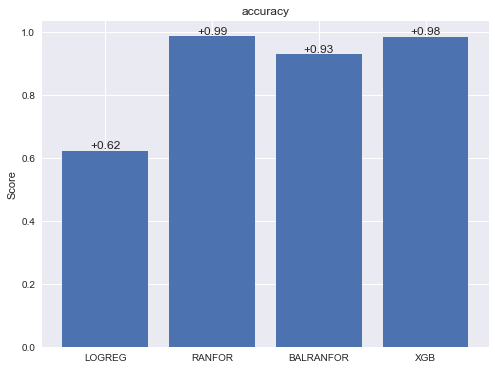

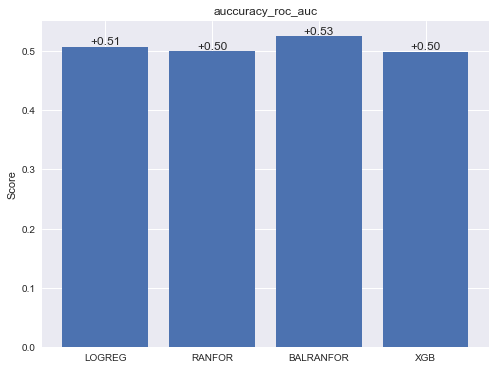

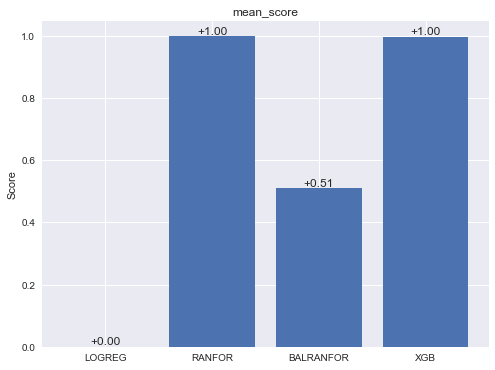

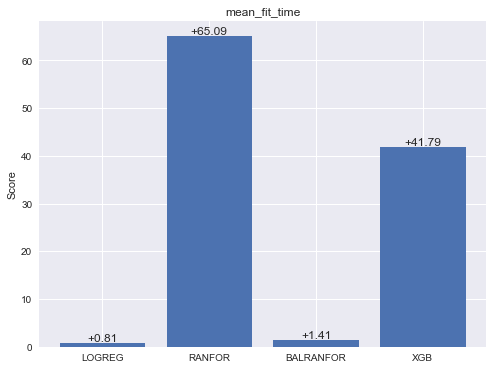

In [25]:
# ---------------------------------------------------
# SL Segmentation 
# ---------------------------------------------------
# split into test and train data 
y_label = df_cluster_train.iloc[:,-2] # label
X_feat = df_cluster_train.iloc[:,:-2] # without Cluster id, LNR, Response
o_sl_segment = SLSegment(y_label, X_feat, p_unbalanced=True, p_print=GC_PRINT, p_plot=GC_PLOT ) 

# estimators = ['LOGREG', 'RANFOR', 'BALRANFOR', 'XGB']  
estimators = GC_ESTIMATORS
df_model_res = o_sl_segment.do_build(estimators) 

if GC_PRINT == True:
    display(df_model_res.head() )
if GC_PLOT == True:
    o_sl_segment.model_res_plot02(df_model_res)  

In [26]:
model = df_model_res['model'][0] 
model.cv_results_['mean_test_score']

array([0.64436919, 0.64436192,        nan, 0.64436679,        nan,
       0.64436661, 0.64432528, 0.64436523, 0.64436616,        nan])

In [27]:
# from imblearn.ensemble import BalancedRandomForestClassifier

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [28]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [29]:
# ---------------------------------------------------
# load data - MAILOUT_TEST
# ---------------------------------------------------
mailout_test = o_df_proj.get_data_test( )

# Reporting 
o_df_stat = DfStat(mailout_test, cols_dic_gen) 
if GC_PRINT == True:
    o_df_stat.print_no( )  
    df_check_gen, df_check_test = o_df_stat.print_colcompare(azdias, mailout_test, False) 
    print('Gen/Test', df_check_gen.shape, df_check_test.shape) 

2022-04-13 14:54:07.372493+00:00 Load Mailout Test Data -------------------------
--------------------------------------------------
Numbers  2022-04-13 14:54:08.947479+00:00
--------------------------------------------------
Number of rows 42,833 and columns 366
Number of NaN values in our DataFrame: 2186757
Number of columns with NaN values: 273
Number of rows with NaN columns > 36: 8673
Gen/Customer (178244, 366) (42833, 366)
Gen/Test (178244, 366) (42833, 366)


2022-04-13 14:54:09.234479+00:00  Preprocessing - Remove Nan Colums -------------
Columns to delete - skip=True
 (19, 17) 



,col_name,type,datatype,inttype,skip,desc,nan_cnt,nan_ratio,unique_cnt,unique,unknown,unknown_cnt,unknown_rate,unknown_skip,unknown_list,skip_reason,not_in_dic
AGER_TYP,AGER_TYP,int64,categorical,True,True,best-ager typology,0,0.000000,5,"[-1, 2, 1, 3, 0]",-1,17997,0.420167,True,"[-1, nan]",high rate of NaNs,
ALTER_KIND1,ALTER_KIND1,float64,,True,True,,161993,0.908827,17,"[nan, 11.0, 8.0, 13.0, 17.0]",,40820,0.953004,True,[nan],high rate of NaNs,X
ALTER_KIND2,ALTER_KIND2,float64,,True,True,,172294,0.966619,16,"[nan, 15.0, 16.0, 11.0, 10.0]",,42071,0.982210,True,[nan],high rate of NaNs,X
ALTER_KIND3,ALTER_KIND3,float64,,True,True,,177002,0.993032,14,"[nan, 16.0, 13.0, 17.0, 15.0]",,42632,0.995307,True,[nan],high rate of NaNs,X
ALTER_KIND4,ALTER_KIND4,float64,,True,True,,178007,0.998670,11,"[nan, 13.0, 15.0, 16.0, 17.0]",,42794,0.999089,True,[nan],high rate of NaNs,X
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,float64,,True,True,,52409,0.294030,25,"[nan, 14.0, 16.0, 10.0, 0.0]",,8118,0.189527,True,[nan],high rate of NaNs,X
D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,10,"[0.0, nan, 10.0, 9.0, 7.0]",,7526,0.175706,True,[nan],high rate of NaNs,
D19_GESAMT_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,float64,numeric,True,True,amount of online transactions within all trans...,51321,0.287926,11,"[0.0, 10.0, 4.0, nan, 5.0]",,7526,0.175706,True,[nan],high rate of NaNs,
D19_KONSUMTYP,D19_KONSUMTYP,float64,categorical,True,True,consumption type,51321,0.287926,7,"[2.0, 9.0, 6.0, 1.0, nan]",,7526,0.175706,True,[nan],high rate of NaNs,
D19_LETZTER_KAUF_BRANCHE,D19_LETZTER_KAUF_BRANCHE,object,categorial,False,True,,51321,0.287926,35,"[D19_TECHNIK, D19_UNBEKANNT, D19_SCHUHE, D19_B...",,7526,0.175706,True,[nan],high rate of NaNs,X


meplot True


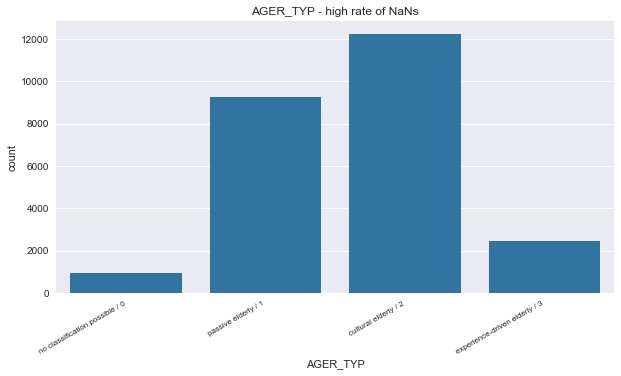

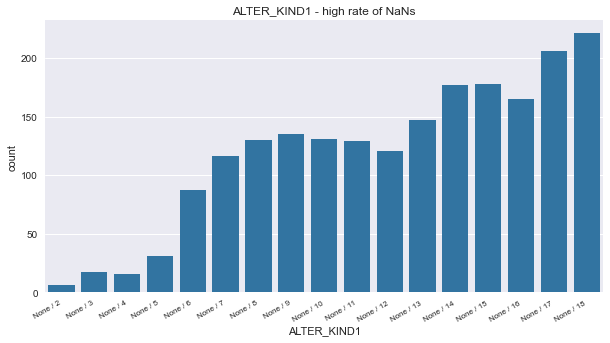

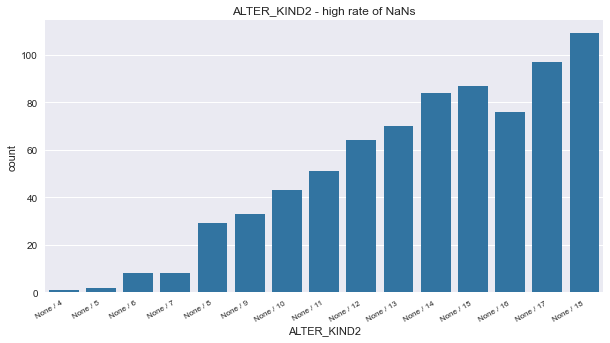

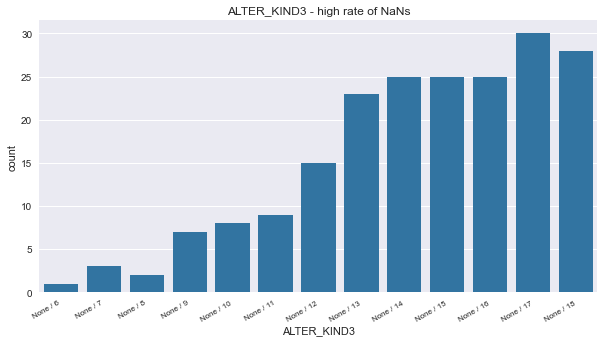

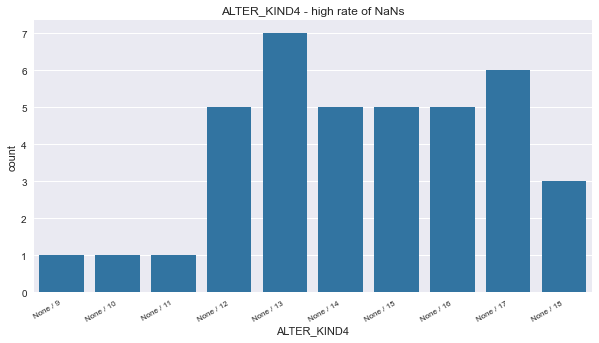

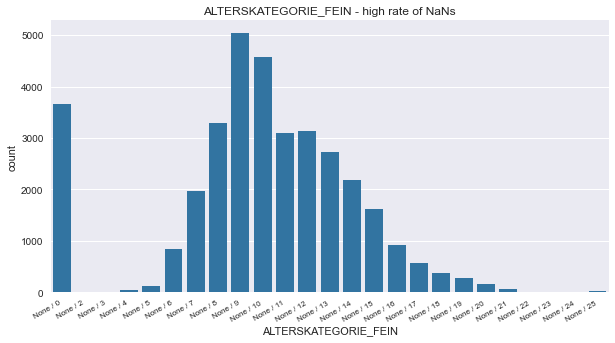

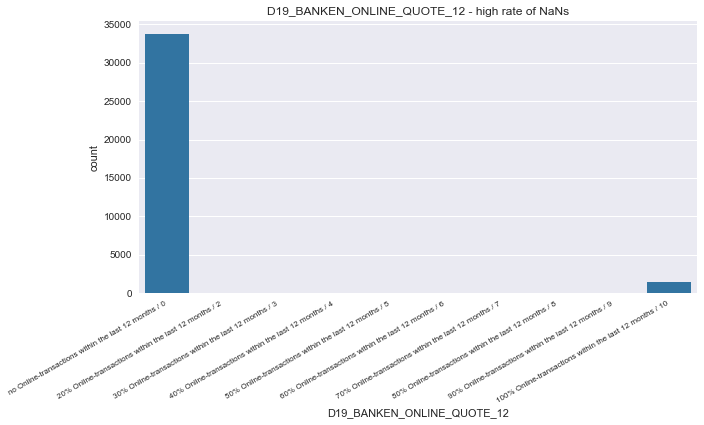

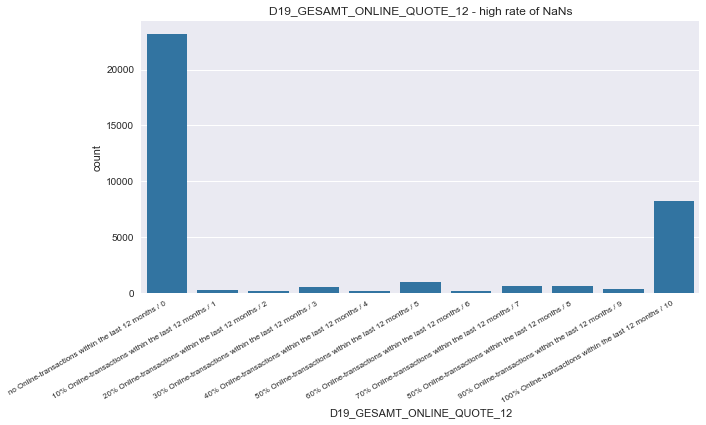

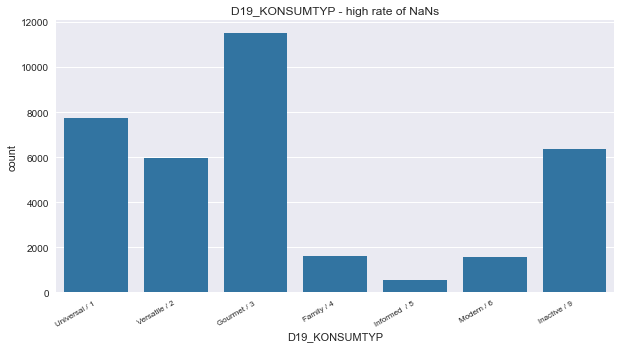

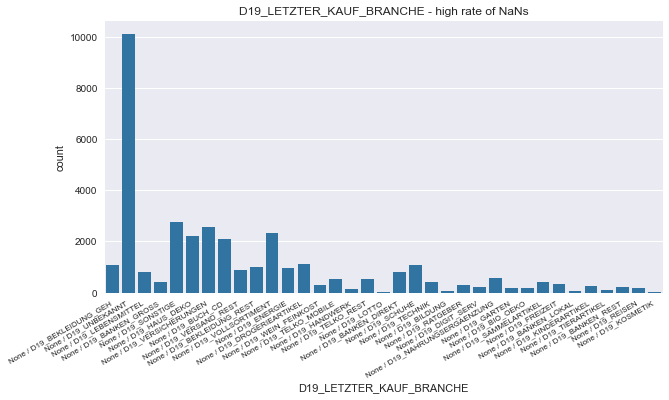

remove AGER_TYP
remove ALTER_KIND1
remove ALTER_KIND2
remove ALTER_KIND3
remove ALTER_KIND4
remove ALTERSKATEGORIE_FEIN
remove D19_BANKEN_ONLINE_QUOTE_12
remove D19_GESAMT_ONLINE_QUOTE_12
remove D19_KONSUMTYP
remove D19_LETZTER_KAUF_BRANCHE
remove D19_LOTTO
remove D19_SOZIALES
remove D19_TELKO_ONLINE_QUOTE_12
remove D19_VERSAND_ONLINE_QUOTE_12
remove D19_VERSI_ONLINE_QUOTE_12
remove EXTSEL992
remove KBA05_BAUMAX
remove KK_KUNDENTYP
remove TITEL_KZ
DataFrame after Column Deletion: (42833, 347)
2022-04-13 14:54:21.973162+00:00  Preprocessing - Remove Nan Rows ---------------
Rows NaN:  7  Rows not-Nan:  42826
2022-04-13 14:54:22.455123+00:00  Feature Reencoding-----------------------------
OST_WEST_KZ --------------------
old ['W' 'O' nan]
new [ 0.  1. nan]
CAMEO_DEUG_2015
old ['2' '5' '7' '9' '4' '6' '1' nan '3' '8' 'X' 3.0 4.0 8.0 6.0 2.0 5.0 7.0
 9.0 1.0]
new [ 2.  5.  7.  9.  4.  6.  1. nan  3.  8.]
CAMEO_DEU_2015 --------------------
old ['2B' '5A' '7A' '9D' '4E' '6B' '2D' '1D' '7E'

In [30]:
# ---------------------------------------------------
# clean data - MAILOUT_TEST
# ---------------------------------------------------
me_print = 'PRINT'
df_clean_test, cols_dic_gen, models_dic_gen, GC_MAX_NAN_COLUMNS = \
    o_df_proj.clean_data(mailout_test, cols_dic_gen, GC_MAX_NAN_COLUMNS)
print('Mailout Test shape - cleaned', df_clean_test.shape)

# compare the columns of the general and the customer dataset 
df_imputed_gen, df_clean_test = o_df_stat.print_colcompare(df_imputed_gen, df_clean_test, 
                                                           True,p_print=GC_PRINT) 
print('Gen imputed/Test cleaned', df_imputed_gen.shape, df_clean_test.shape) 

In [31]:
# ---------------------------------------------------
# imputing - MAILOUT_TEST
# --------------------------------------------------- 
df_imputed_test,  models_dic_gen = DfDataPrep01.do_imputing_mean(
    df_clean_test, 'mean', models_dic_gen ) 
print('Gen imputed/Test imputed', df_imputed_gen.shape, df_clean_test.shape) 

# Reporting 
# compare the columns of the general and the customer dataset 
if GC_PRINT == True:
    df_check_1, df_check_2 = o_df_stat.print_colcompare(df_imputed_gen, df_imputed_test, False) 
    print('Gen/Test - imputed', df_check_1.shape, df_check_2.shape)

2022-04-13 14:54:26.357213+00:00  feature imputing ------------------------------
Gen imputed/Test imputed (122636, 664) (42826, 664)
Gen/Customer (122636, 664) (42826, 664)
Gen/Test - imputed (122636, 664) (42826, 664)


In [32]:
# ---------------------------------------------------
# PCA - MAILOUT_TEST
# ---------------------------------------------------
# Apply PCA to the data.
pca_test, df_pca_test, scaler_test, models_dic_gen = \
        DfPca.do_pca(selected_pca_no, df_imputed_test, models_dic_gen, GC_PRINT )
print('Test - PCA', df_pca_test.shape) 

2022-04-13 14:54:30.881461+00:00  General PCA -----------------------------------
old scaler
old pca model
Test - PCA (42826, 70)


In [33]:
# ---------------------------------------------------
# KMeans - MAILOUT_TEST
# ---------------------------------------------------
k_test_score, k_test_cluster, k_test_center, k_test_label = \
        o_df_kmeans.get_kmeans(df_pca_test, selected_cluster_no )

2022-04-13 14:54:31.538056+00:00 KMeans 20 --------------------------------------
KMeans - Shape  (20, 70) 5793292.6968041565 No of Labels:  42826  Score:  5793292.696804177  DataFrame:  (42826, 70)


In [34]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

unique
 NaN    42826
Name: RESPONSE, dtype: int64
nan cnt 42826
nan rate 1.0
Mailout Cluster Shape (42826, 73)
Test - Cluster (42826, 73)


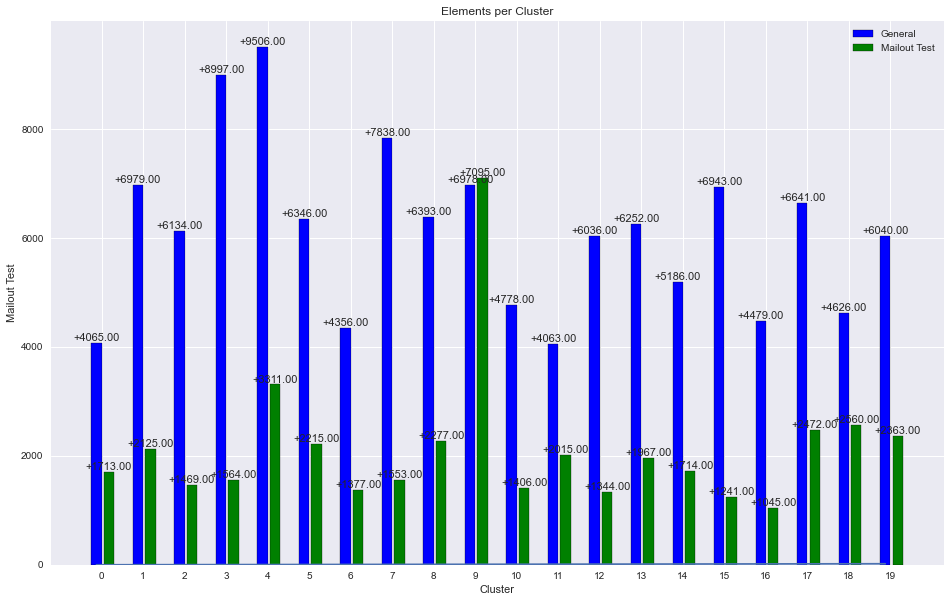

(42826, 73)
(42826, 2)
-42827
-42827


In [35]:
# Cluster
# ---------------------------------------------------
df_lnr_test = pd.DataFrame(data={'LNR' : mailout_test['LNR'], 
                                  'RESPONSE' : np.nan})
df_cluster_test, df_lnr_test = o_df_proj.do_cluster(df_clean_test, df_pca_test, 
                                k_test_label, df_lnr_test, 'PRINT') 
print('Test - Cluster', df_cluster_test.shape) 

fi_me = 'E' # E=Export, I=Import
if fi_me == 'E':
    fi_cluster_test = open("./data/df_cluster_test.pickle","wb")
    pickle.dump(df_cluster_test, fi_cluster_test)
    fi_cluster_test.close()
else:
    fi_cluster_test = open("./data/df_cluster_test.pickle","rb")
    df_cluster_test = pickle.load(fi_cluster_test)

if GC_PLOT == True:
    o_df_kmeans.plot_kmeans_cluster(k_gen_cluster, k_test_cluster, 'General', 
                                    'Mailout Test')

if GC_PRINT == True:
    print(df_cluster_test.shape)
    print(df_lnr_test.shape)
    print(~df_cluster_test['LNR'].isin(df_lnr_test['LNR']).sum().sum())
    print(~df_lnr_test['LNR'].isin(df_cluster_test['LNR']).sum().sum())
    df_check2 = df_lnr_test[~df_lnr_test['LNR'].isin(df_cluster_test['LNR'])]
    df_check2.shape
    # df_check3=df_lnr_test.intersect(df_lnr_test)
    # df_check3.shape
    df_check3 = pd.merge(df_cluster_test, df_lnr_test, how='inner', on=['LNR'] )
    df_check3.shape
    df_check3.head()


In [36]:
# ---------------------------------------------------
# Prediction on Test Data 
# ---------------------------------------------------
model_no = 0
model = df_model_res['model'][model_no]
df_test = df_cluster_test.iloc[:,:-2]
y_pred = model.predict_proba(df_test)[:,1]

if GC_PRINT == True:
    display(df_cluster_test.head())
    print(df_cluster_test.shape)
    print(df_model_res['model'][model_no])
    display(df_test.head())
    print('pred', len(y_pred), y_pred) 
print('predicted', y_pred.shape)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,cluster_no,RESPONSE,LNR
0,5.472345,-2.100770,6.678129,2.159697,3.726175,-2.864050,2.868530,3.145899,1.199740,-0.234094,1.347095,-2.745730,0.523298,0.772502,0.064132,-1.705480,4.428663,-2.089980,1.981813,0.898147,-4.823700,-0.688637,-2.351088,1.167516,2.614583,0.678144,-1.931125,-1.263335,0.259864,0.743553,-0.918378,-2.895037,0.513058,-1.057578,-2.781345,-1.952765,0.213946,1.040431,2.700146,0.227181,1.150175,-0.506341,-1.201936,-0.372951,0.903958,0.513328,1.495259,-0.691214,-0.198028,0.638444,-1.314611,0.813420,1.234459,-0.160362,0.664733,1.271390,0.218987,0.638558,-0.726847,1.541575,-0.356126,2.224077,1.977201,-0.616237,-0.346607,3.667769,1.709445,0.105256,-0.196509,-4.087042,2,NaN,1754
1,-0.342822,-5.410306,2.061629,1.158580,1.478577,-0.930098,-1.186834,4.345357,2.821667,-0.115262,-1.743557,-2.322515,-0.708230,-1.127268,0.569853,-0.145099,-0.801989,0.859134,0.241912,3.847243,1.976729,-0.628227,2.954585,1.478783,-1.016642,0.314966,1.669589,-1.970929,-0.171755,-0.842489,2.502042,-1.265099,-0.254591,-0.883065,0.143804,-2.183487,2.633685,-0.157537,1.014053,-0.508202,-0.431495,-1.494926,0.265595,3.315109,-0.304673,-2.628658,-0.001797,0.821801,-0.512093,-1.248682,-0.621435,-0.939365,-0.277546,0.749736,0.986125,0.902308,-0.355821,0.801930,0.103260,0.629686,1.022267,2.297555,2.199944,0.984431,0.406039,-0.230550,-1.593873,0.005377,0.917589,-3.133287,4,NaN,1770
2,4.629037,-4.652974,1.780650,0.684265,-0.378250,-2.678438,0.434859,-1.859637,-1.585511,-3.010915,-0.061723,-1.224838,-0.367178,-1.678720,1.090435,-0.656811,-3.142033,-3.619053,2.040982,-2.344603,1.507946,0.449366,-4.170154,3.165553,0.711733,-0.070554,0.621619,-1.179975,-0.466255,0.613970,-1.854388,0.376526,1.285926,0.494070,-2.292977,1.179884,-0.812205,3.216410,-0.804862,-0.145834,-1.118497,0.644837,0.814799,-1.909959,0.834717,1.499255,1.107467,-1.133648,-0.291308,0.057458,-0.119921,2.314861,0.371416,-3.402368,3.563277,1.938759,-1.668129,0.713659,0.708290,1.299539,2.265560,-1.482635,-0.639536,0.770761,-0.236008,0.434476,-1.437602,0.606530,-1.137135,-2.382429,8,NaN,1465
3,2.696285,-3.850592,-5.174615,0.368412,-1.505184,-2.378679,1.771640,-1.741755,-2.734388,-1.304613,-0.500968,-2.853094,-2.027598,1.122651,3.284723,1.787696,0.052384,4.059316,2.754190,1.440654,-0.920441,-0.211180,0.999141,1.073215,-1.350610,0.716730,0.589503,1.033637,-2.332099,0.813382,1.475596,0.994157,-0.861587,-2.162220,-0.815075,0.701421,1.119948,-0.675833,-1.115396,0.483285,-0.381700,1.443535,1.020239,-0.361784,-0.037521,0.235443,-0.181386,-1.681604,-2.403144,0.595316,0.743746,-1.325786,2.595882,-0.771416,0.608885,-2.312802,0.520914,-2.101771,-1.332733,1.923757,2.677629,0.240100,-1.842112,-0.122216,0.201116,-0.600418,-3.578255,1.698922,-2.291315,-0.197087,19,NaN,1470
4,12.605611,4.634117,-3.592823,8.597181,-1.588011,-0.752322,-5.238838,4.736465,5.203582,-1.856012,-1.327878,-2.229740,0.007647,5.813892,2.093962,2.285283,-1.171486,2.131808,-1.917405,-0.281017,-2.774431,-1.727449,1.912248,0.974768,-1.403627,0.600731,1.034263,0.760070,2.125223,0.142589,1.697117,4.496295,0.501703,-0.530661,1.150042,-2.778579,0.202414,1.314523,-0.408284,2.445237,-1.496821,-0.963166,-1.177752,-1.235299,1.804524,-1.221028,-2.918915,-1.844088,-0.978112,1.409676,1.500565,-2.065013,0.661196,-1.092379,-0.322877,-0.699854,1.425271,0.951427,0.060397,0.291882,1.962493,1.735915,-0.162436,5.052181,0.579495,0.424113,-3.015142,1.762864,-0.920083,-1.697340,12,NaN,1478


(42826, 73)
RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=2, random_state=42),
                   estimator=Pipeline(steps=[('clf', LogisticRegression())]),
                   param_distributions={'clf__C': [0.1, 1, 10, 100, 1000],
                                        'clf__max_iter': [100, 1000, 2500,
                                                          5000],
                                        'clf__penalty': ['l1', 'l2', 'none'],
                                        'clf__solver': ['lbfgs', 'newton-cg',
                                                        'liblinear', 'sag',
                                                        'saga']},
                   return_train_score=True, scoring='roc_auc')


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,cluster_no
0,5.472345,-2.100770,6.678129,2.159697,3.726175,-2.864050,2.868530,3.145899,1.199740,-0.234094,1.347095,-2.745730,0.523298,0.772502,0.064132,-1.705480,4.428663,-2.089980,1.981813,0.898147,-4.823700,-0.688637,-2.351088,1.167516,2.614583,0.678144,-1.931125,-1.263335,0.259864,0.743553,-0.918378,-2.895037,0.513058,-1.057578,-2.781345,-1.952765,0.213946,1.040431,2.700146,0.227181,1.150175,-0.506341,-1.201936,-0.372951,0.903958,0.513328,1.495259,-0.691214,-0.198028,0.638444,-1.314611,0.813420,1.234459,-0.160362,0.664733,1.271390,0.218987,0.638558,-0.726847,1.541575,-0.356126,2.224077,1.977201,-0.616237,-0.346607,3.667769,1.709445,0.105256,-0.196509,-4.087042,2
1,-0.342822,-5.410306,2.061629,1.158580,1.478577,-0.930098,-1.186834,4.345357,2.821667,-0.115262,-1.743557,-2.322515,-0.708230,-1.127268,0.569853,-0.145099,-0.801989,0.859134,0.241912,3.847243,1.976729,-0.628227,2.954585,1.478783,-1.016642,0.314966,1.669589,-1.970929,-0.171755,-0.842489,2.502042,-1.265099,-0.254591,-0.883065,0.143804,-2.183487,2.633685,-0.157537,1.014053,-0.508202,-0.431495,-1.494926,0.265595,3.315109,-0.304673,-2.628658,-0.001797,0.821801,-0.512093,-1.248682,-0.621435,-0.939365,-0.277546,0.749736,0.986125,0.902308,-0.355821,0.801930,0.103260,0.629686,1.022267,2.297555,2.199944,0.984431,0.406039,-0.230550,-1.593873,0.005377,0.917589,-3.133287,4
2,4.629037,-4.652974,1.780650,0.684265,-0.378250,-2.678438,0.434859,-1.859637,-1.585511,-3.010915,-0.061723,-1.224838,-0.367178,-1.678720,1.090435,-0.656811,-3.142033,-3.619053,2.040982,-2.344603,1.507946,0.449366,-4.170154,3.165553,0.711733,-0.070554,0.621619,-1.179975,-0.466255,0.613970,-1.854388,0.376526,1.285926,0.494070,-2.292977,1.179884,-0.812205,3.216410,-0.804862,-0.145834,-1.118497,0.644837,0.814799,-1.909959,0.834717,1.499255,1.107467,-1.133648,-0.291308,0.057458,-0.119921,2.314861,0.371416,-3.402368,3.563277,1.938759,-1.668129,0.713659,0.708290,1.299539,2.265560,-1.482635,-0.639536,0.770761,-0.236008,0.434476,-1.437602,0.606530,-1.137135,-2.382429,8
3,2.696285,-3.850592,-5.174615,0.368412,-1.505184,-2.378679,1.771640,-1.741755,-2.734388,-1.304613,-0.500968,-2.853094,-2.027598,1.122651,3.284723,1.787696,0.052384,4.059316,2.754190,1.440654,-0.920441,-0.211180,0.999141,1.073215,-1.350610,0.716730,0.589503,1.033637,-2.332099,0.813382,1.475596,0.994157,-0.861587,-2.162220,-0.815075,0.701421,1.119948,-0.675833,-1.115396,0.483285,-0.381700,1.443535,1.020239,-0.361784,-0.037521,0.235443,-0.181386,-1.681604,-2.403144,0.595316,0.743746,-1.325786,2.595882,-0.771416,0.608885,-2.312802,0.520914,-2.101771,-1.332733,1.923757,2.677629,0.240100,-1.842112,-0.122216,0.201116,-0.600418,-3.578255,1.698922,-2.291315,-0.197087,19
4,12.605611,4.634117,-3.592823,8.597181,-1.588011,-0.752322,-5.238838,4.736465,5.203582,-1.856012,-1.327878,-2.229740,0.007647,5.813892,2.093962,2.285283,-1.171486,2.131808,-1.917405,-0.281017,-2.774431,-1.727449,1.912248,0.974768,-1.403627,0.600731,1.034263,0.760070,2.125223,0.142589,1.697117,4.496295,0.501703,-0.530661,1.150042,-2.778579,0.202414,1.314523,-0.408284,2.445237,-1.496821,-0.963166,-1.177752,-1.235299,1.804524,-1.221028,-2.918915,-1.844088,-0.978112,1.409676,1.500565,-2.065013,0.661196,-1.092379,-0.322877,-0.699854,1.425271,0.951427,0.060397,0.291882,1.962493,1.735915,-0.162436,5.052181,0.579495,0.424113,-3.015142,1.762864,-0.920083,-1.697340,12


pred 42826 [0.68041868 0.80238819 0.34144375 ... 0.43733562 0.63686727 0.65735018]
predicted (42826,)


In [37]:
y_test = df_cluster_test['RESPONSE']
df_cluster_test.head()
df_lnr_test.head()

,LNR,RESPONSE
0,1754,NaN
1,1770,NaN
2,1465,NaN
3,1470,NaN
4,1478,NaN


In [38]:
print('label', y_label.shape, y_pred.shape)
display(y_label.head(2))
display(y_pred[:2])

# fpr, tpr, thresholds = metrics.roc_curve(y_label, y_pred, pos_label='default') 
# df_roc = pd.DateFrame({'recall': tpr, 'specificity': 1 - fpr} ) 
# df_roc.head()

label (42952,) (42826,)


0    0
1    0
Name: RESPONSE, dtype: int64

array([0.68041868, 0.80238819])

In [39]:
# Create the final file to be submitted (In different model results)
kaggle_res = pd.DataFrame(data={'LNR' : df_lnr_test['LNR'], 'RESPONSE' : y_pred})
print('kaggle', kaggle_res.head())

kaggle     LNR  RESPONSE
0  1754  0.680419
1  1770  0.802388
2  1465  0.341444
3  1470  0.572600
4  1478  0.308958


In [40]:
# kaggle_res.to_csv('./data/kaggle_res_xgboost.csv', index=False)



<AxesSubplot:>

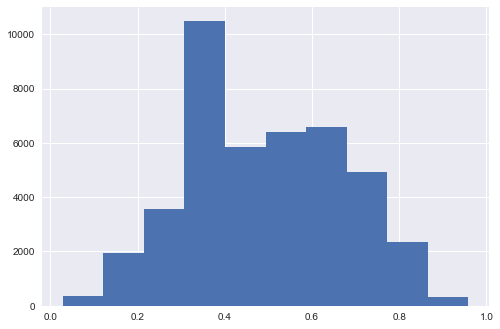

In [41]:
kaggle_res['RESPONSE'].hist()